In [289]:
options(repr.plot.width=17, repr.plot.height=14)

library(plyr)
library(dplyr)
library(ggplot2)
library(cowplot)
library(hydroPSO)
library(data.table)
library(doParallel)
library(RColorBrewer)
library(MASS)
library(kernlab)

# Objective function
#f <- function(x) sin(.2*x[[1]]*x[[2]]) + sin(.5 * x[[1]])
#f <- function(x) 2*sin(.1*x[[1]]*x[[2]])
f <- function(x) sin(2*x[[1]]) - .1*x[[2]]*cos(3*x[[2]])
f.noise <- 1e-7

# GP prior mean
prior.mu <- function(x) 0

# OAK parameters
input.means <- c(5, 5)
input.vars <- c(2, 2)

# Plot values
plot.gps <- FALSE
x.limits <- c(0, 10)
y.limits <- c(-3, 3)

# Other values
seed <- 293526
n.cores <- 8
n.points <- 100
n.points.test <- 1000

# Kernel types: se, ak, ak1, ak2, oak.gaussian
#kernel.type <- 'oak.gaussian'
color.breaks <- seq(-2,2,.25)

# Performance measures: loglikelihood, test.mse
performance.measure <- 'test.mse'

In [290]:
# Function definitions

get.init.params <- function(kernel.type) {
    if (kernel.type == 'se') {
      initial.pars <- c(.5, 1)
      lower.bounds <- c(.01, .1)
      upper.bounds <- c(10, 10)
    } else if (kernel.type == 'ak') {
      initial.pars <- c(2,2,2,2)
      lower.bounds <- c(.01, .01, 0, 0)
      upper.bounds <- c(10, 10, 10, 10)
    } else if (kernel.type == 'ak1') {
      initial.pars <- c(.5, .5, 1)
      lower.bounds <- c(.01, .01, .1)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'ak2') {
      initial.pars <- c(.5, .5, 1)
      lower.bounds <- c(.01, .01, .1)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'oak.gaussian') {
      initial.pars <- c(5, 4, 3, 2, 1)
      lower.bounds <- c(.01, .01, 0, 0, 0)
      upper.bounds <- c(10, 10, 10, 10, 10)
    } else if (kernel.type == 'oak.gaussian0') {
      initial.pars <- c(1)
      lower.bounds <- c(0)
      upper.bounds <- c(10)
    } else if (kernel.type == 'oak.gaussian1') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, 0)
      upper.bounds <- c(10, 10, 10)
    } else if (kernel.type == 'oak.gaussian2') {
      initial.pars <- c(1, 1, 1)
      lower.bounds <- c(.01, .01, 0)
      upper.bounds <- c(10, 10, 10)
    }
    return(list(
        initial.pars=initial.pars,
        lower.bounds=lower.bounds,
        upper.bounds=upper.bounds
    ))
}

build.k <- function(type, l, sigma2) {
  if (type == 'se') {
    k <- function(x,x2) {
      kernel <- rbfdot(sigma=1/(2*l^2))
      k <- kernelMatrix(kernel, as.matrix(x), as.matrix(x2))
      return(sigma2*k)
    }
    return(k)
  } else if (type == 'ak') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[1]*(k1 + k2) + sigma2[2]*k1*k2)
    }
    return(k)
  } else if (type == 'ak1') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[1]*(k1 + k2))
    }
    return(k)
  } else if (type == 'ak2') {
    k <- function(x,x2) {
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k1 <- kernelMatrix(kernel1, as.matrix(x[,1]), as.matrix(x2[,1]))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      return(sigma2[2]*k1*k2)
    }
    return(k)
  } else if (type == 'oak.gaussian') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[1] + sigma2[2]*(k1 + k2) + sigma2[3]*k1*k2)
    }
    return(k)
  } else if (type == 'oak.gaussian0') {
    k <- function(x,x2) {
      return(matrix(sigma2[1], nrow=nrow(x), ncol=nrow(x2)))
    }
    return(k)
  } else if (type == 'oak.gaussian1') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[2]*(k1 + k2))
    }
    return(k)
  } else if (type == 'oak.gaussian2') {
    k <- function(x,x2) {
      m1 <- as.matrix(x[,1])
      m2 <- as.matrix(x2[,1])
        
      kernel1 <- rbfdot(sigma=1/(2*l[1]^2))        
      kerneld <- function(x1,x2) {
          -(2*crossprod(x1,x2) - crossprod(x1) - crossprod(x2))
      }       
        
      k1 <- kernelMatrix(kernel1, m1, m2)       
      exp.numerator1 <- -log(kernelMatrix(rbfdot(), m1-input.means[1], m2-input.means[1]))
      #exp.numerator1 <- (x[,1]-input.means[1])^2 + (x2[,1]-input.means[1])^2
      k1 <- k1 - 
        l[1]*sqrt(l[1]^2+2*input.vars[1]^2)/(l[1]^2+input.vars[1]^2) *
        exp(-exp.numerator1/(2*(l[1]^2+input.vars[1]^2)))
      
        
      kernel2 <- rbfdot(sigma=1/(2*l[2]^2))
      k2 <- kernelMatrix(kernel2, as.matrix(x[,2]), as.matrix(x2[,2]))
      exp.numerator2 <- -log(kernelMatrix(rbfdot(), m1-input.means[2], m2-input.means[2]))
      #exp.numerator2 <- (x[,2]-input.means[2])^2 + (x2[,2]-input.means[2])^2
      k2 <- k2 - 
        l[2]*sqrt(l[2]^2+2*input.vars[2]^2)/(l[2]^2+input.vars[2]^2) *
        exp(-exp.numerator2/(2*(l[2]^2+input.vars[2]^2)))
      return(sigma2[3]*k1*k2)
    }
    return(k)
  }
}

calculate.regression.model <- function(X, y, k) {
  if (nrow(X) == 0) {
    K <- numeric(0)
    Ki <- K
  } else {
    K <- k(X,X)
    if (nrow(X) == 1) {
      Ki <- 1/(K + f.noise)
    } else {
      # ginv vs solve
      Ki <- solve(matrix(unlist(K),nrow=nrow(K)) + f.noise*diag(nrow(K)))
    }
  }
  
  fs <- function(Xs) {
    if (nrow(X) == 0)
      return(prior.mu(Xs))
    
    Ks <- k(Xs, X)
    # Ks <- matrix(unlist(Ks),nrow=nrow(Ks))
    return(prior.mu(Xs) + Ks %*% Ki %*% (y - prior.mu(Xs)))
  }
  
  
  sigma <- function(Xs) {
    Kss <- k(Xs, Xs)
    # Kss <- apply(Xs, 1, function(r) k(r,r))
    
    if (nrow(X) == 0)
      return(Kss)
    
    Ks <- k(Xs, X)
    S <- Kss - Ks %*% Ki %*% t(Ks)
    # if (Xs %in% observed.x && f.noise == 0)
    #   S <- matrix(0) # Due to numerical instability values already observed haved a non-zero sigma, forcing 0 here
    S <- apply(S, 1:2, function(x) max(x,0)) # Numerical instability, (small) negative values should be 0
    return(S)
  }
  
  if (nrow(X) == 0) {
    best.x <- c(0,0)
    best.y <- prior.mu(c(0,0))
  } else {
    best.x <- X[which.max(y),]
    best.y <- max(y)
  }
  
  return(list(mean=fs, cov=sigma, best.x=best.x, best.y=best.y, K=K))
}

calculate.loglik <- function(gp.model, observed.x, observed.y) {
  Lu <- matrix(chol(gp.model$K), nrow=nrow(gp.model$K))
  Ll <- t(Lu)
  S1 <- forwardsolve(Ll, observed.y)
  S2 <- backsolve(Lu, S1)
  
  log.lik <- -sum(log(diag(Ll))) - .5 * observed.y %*% S2 - 0.5 * nrow(observed.x) + log(2*pi)
  return(log.lik)
}

calculate.test.mse <- function(gp.model, observed.x, observed.y) {
  set.seed(234)
  x.test <- data.frame(x1=runif(n.points.test, 0, 10), x2=runif(n.points.test, 0, 10))
  
  y.test <- apply(x.test, 1, f)
  y.model <- gp.model$mean(x.test)
  
  mse <- mean((y.test - y.model)^2)
  return(mse)
} 

if (performance.measure == 'loglikelihood') {
  calculate.performance <- calculate.loglik
  fnscale <- -1
} else if (performance.measure == 'test.mse') {
  calculate.performance <- calculate.test.mse
  fnscale <- 1
}

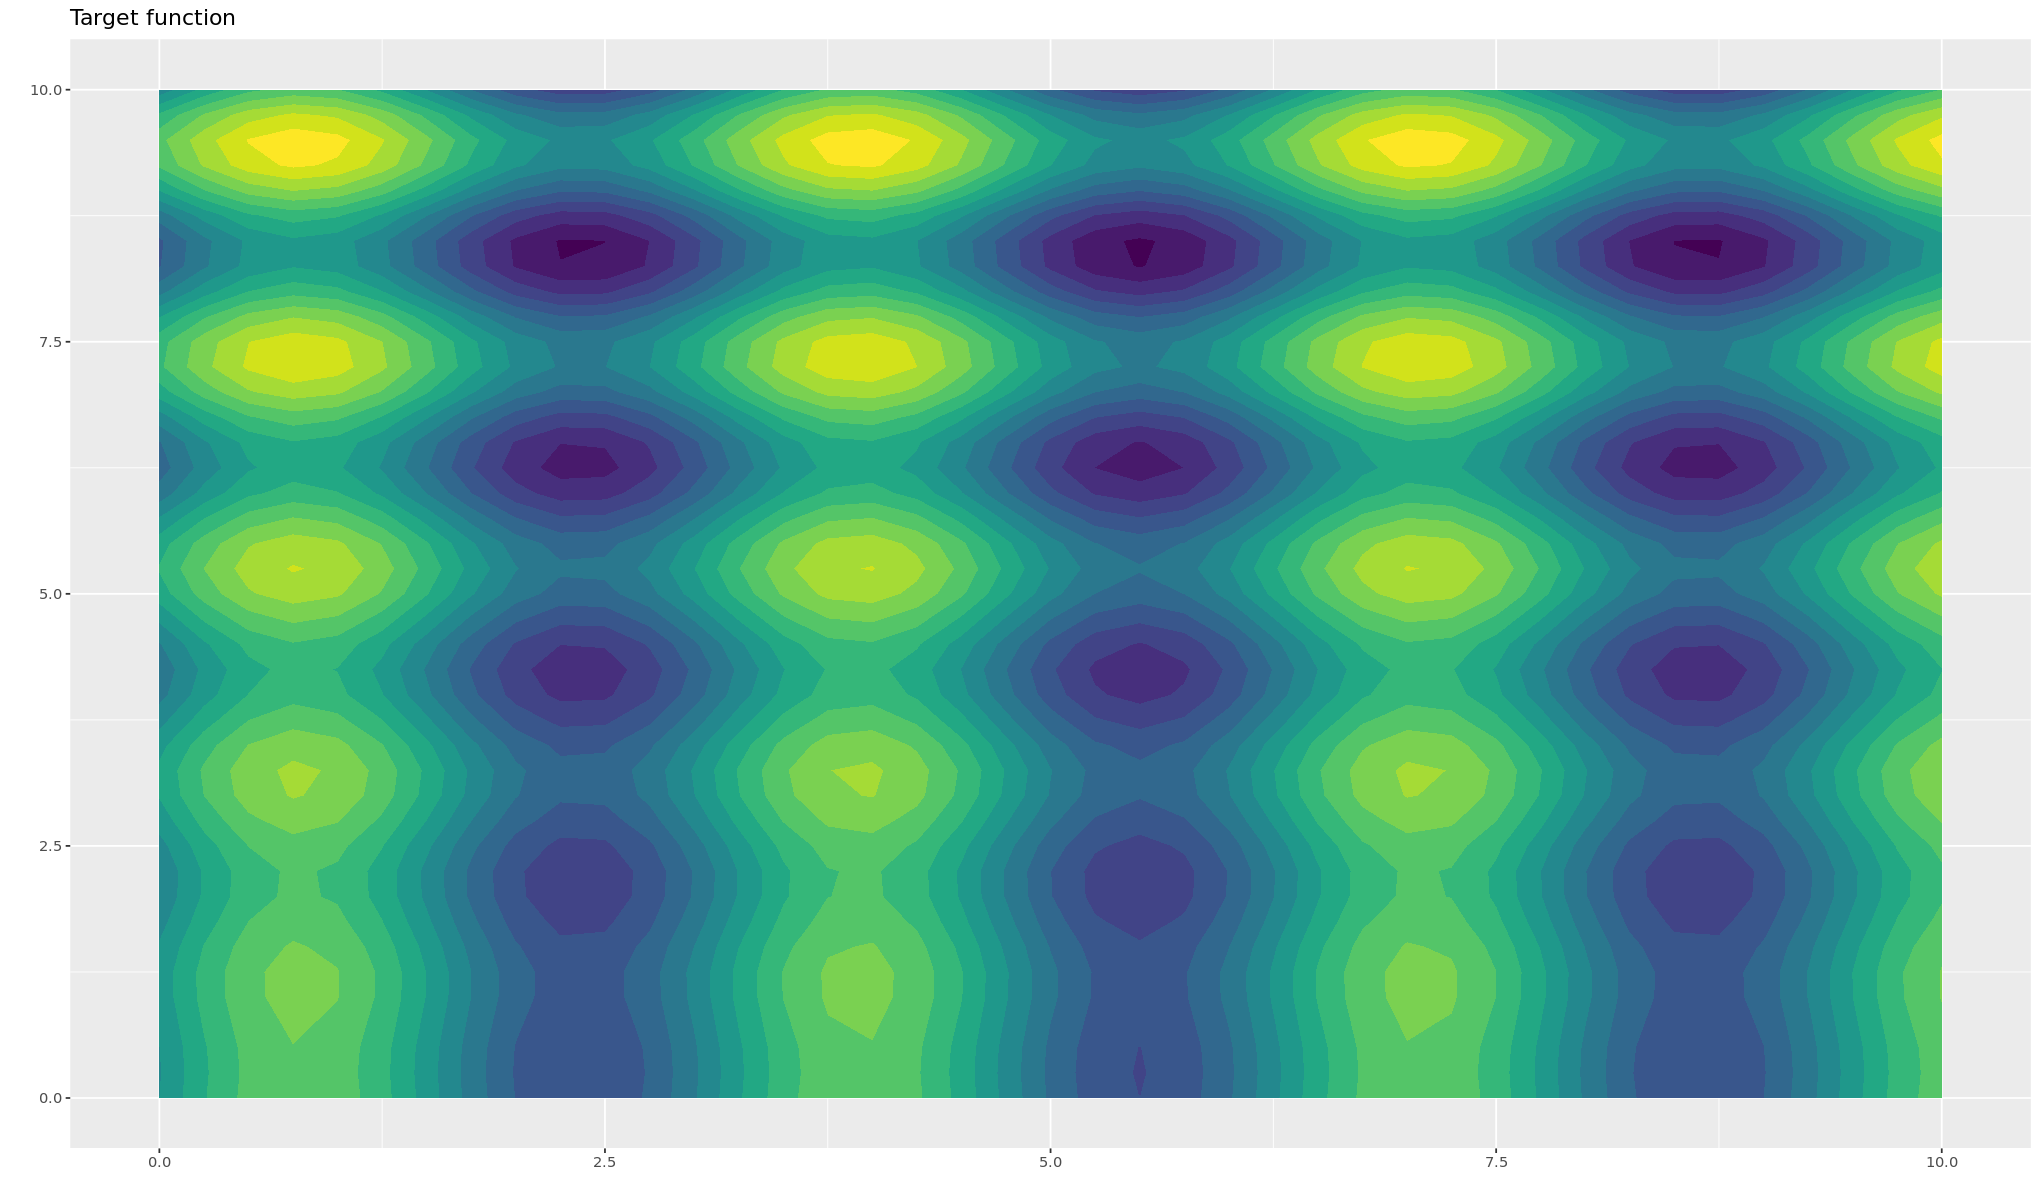

In [371]:
# Build target function plot

x1.plt <- seq(0, 10, .25)
x2.plt <- seq(0, 10, .25)
df.f <- expand.grid(x1.plt, x2.plt)
names(df.f) <- c('x', 'y')
x.plt <- df.f
df.f$z <- apply(df.f, 1, f)
names(x.plt) <- c('x1', 'x2')
xx <- x.plt

plt.f <- ggplot(df.f, aes(x=x, y=y, z=z)) + 
  geom_contour_filled(
    breaks=color.breaks
  ) +
  scale_fill_viridis_d(drop=FALSE) +
  theme(legend.position = "none") +
  xlab('') +
  ylab('') +
  ggtitle('Target function')

options(repr.plot.width=17, repr.plot.height=10)
plt.f

In [294]:
# Define hyperparameter optimization

calculate.params.ll <- function(pars, kernel.type, verbose=TRUE) {
  if (kernel.type == 'se') {
      l <- pars[1]
      sigma2 <- pars[2]
  } else if (kernel.type == 'ak') {
      l <- pars[1:2]
      sigma2 <- pars[3:4]
  } else if (kernel.type == 'ak1') {
      l <- pars[1:2]
      sigma2 <- pars[3]
  } else if (kernel.type == 'ak2') {
      l <- pars[1:2]
      sigma2 <- pars[3]
  } else if (kernel.type == 'oak.gaussian') {
      l <- pars[1:2]
      sigma2 <- pars[3:5]
  }
  
  k <- build.k(kernel.type, l, sigma2)
  
  observed.x <- data.frame(x1=runif(n.points, 0, 10), x2=runif(n.points, 0, 10))
  observed.y <- apply(observed.x, 1, f)
  
  gp.model <- calculate.regression.model(observed.x, observed.y, k)
  
  perf <- calculate.performance(gp.model, observed.x, observed.y)
  
  if (plot.gps) {
    cl <- makeCluster(n.cores)
    clusterExport(cl, ls(1))
    registerDoParallel(cl)
    
    df.f.model <- df.f
    df.f.model$z <- foreach(x=iter(xx, by='row'), .combine='c') %dopar% {
      gp.model$mean(data.frame(x))
    }
    
    stopCluster(cl)
    
    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(paste0('Gaussian process (Log-likelihood: ', perf, ')'))
  
    plt2 <- plot_grid(plt.f, plt, ncol=2, align='h')
    print(plt2)
  }
  
  if (performance.measure == 'loglikelihood') perf.name <- 'll'
  else if (performance.measure == 'test.mse') perf.name <- 'mse'
  if (verbose) {
      message(paste0('l=',paste0(l, collapse=','),
                     ', sigma2=', paste0(sigma2, collapse=','), ' (', perf.name, '=', perf, ')'), appendLF=FALSE )
  }
  return(perf)
}


# Squared Exponential kernel optimization

In [391]:
set.seed(1323)
kernel.type <- 'se'
optim.params <- get.init.params(kernel.type)

optim.result <- optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        temp=1000,
                        tmax=1000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')

l.se <- optim.result$par[1]
sigma2.se <- optim.result$par[2]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”
l=0.5, sigma2=1 (mse=0.225348501101351)
l=0.501, sigma2=1 (mse=0.232124413810239)
l=0.499, sigma2=1 (mse=0.233424687740124)
l=0.5, sigma2=1.001 (mse=0.232773910100034)
l=0.5, sigma2=0.999 (mse=0.232773910808401)
l=1.1501369649428, sigma2=1.00000035418328 (mse=0.199194250068047)
l=1.1511369649428, sigma2=1.00000035418328 (mse=0.199798767524374)
l=1.1491369649428, sigma2=1.00000035418328 (mse=0.198591476170197)
l=1.1501369649428, sigma2=1.00100035418328 (mse=0.199193978052135)
l=1.1501369649428, sigma2=0.99900035418328 (mse=0.199194522627981)
l=0.837122288238339, sigma2=1.00000018365834 (mse=0.103957931456607)
l=0.838122288238339, sigma2=1.00000018365834 (mse=0.10391520073323)
l=0.836122288238339, sigma2=1.00000018365834 (mse=0.10400298832615)
l=0.837122288238339, sigma2=1.00100018365834 (mse=0.103957921724646)
l=0.837122288238339


Optimization results:
 Params=0.855855903356729,1.00001518784158
 Performance=0.10354582899533


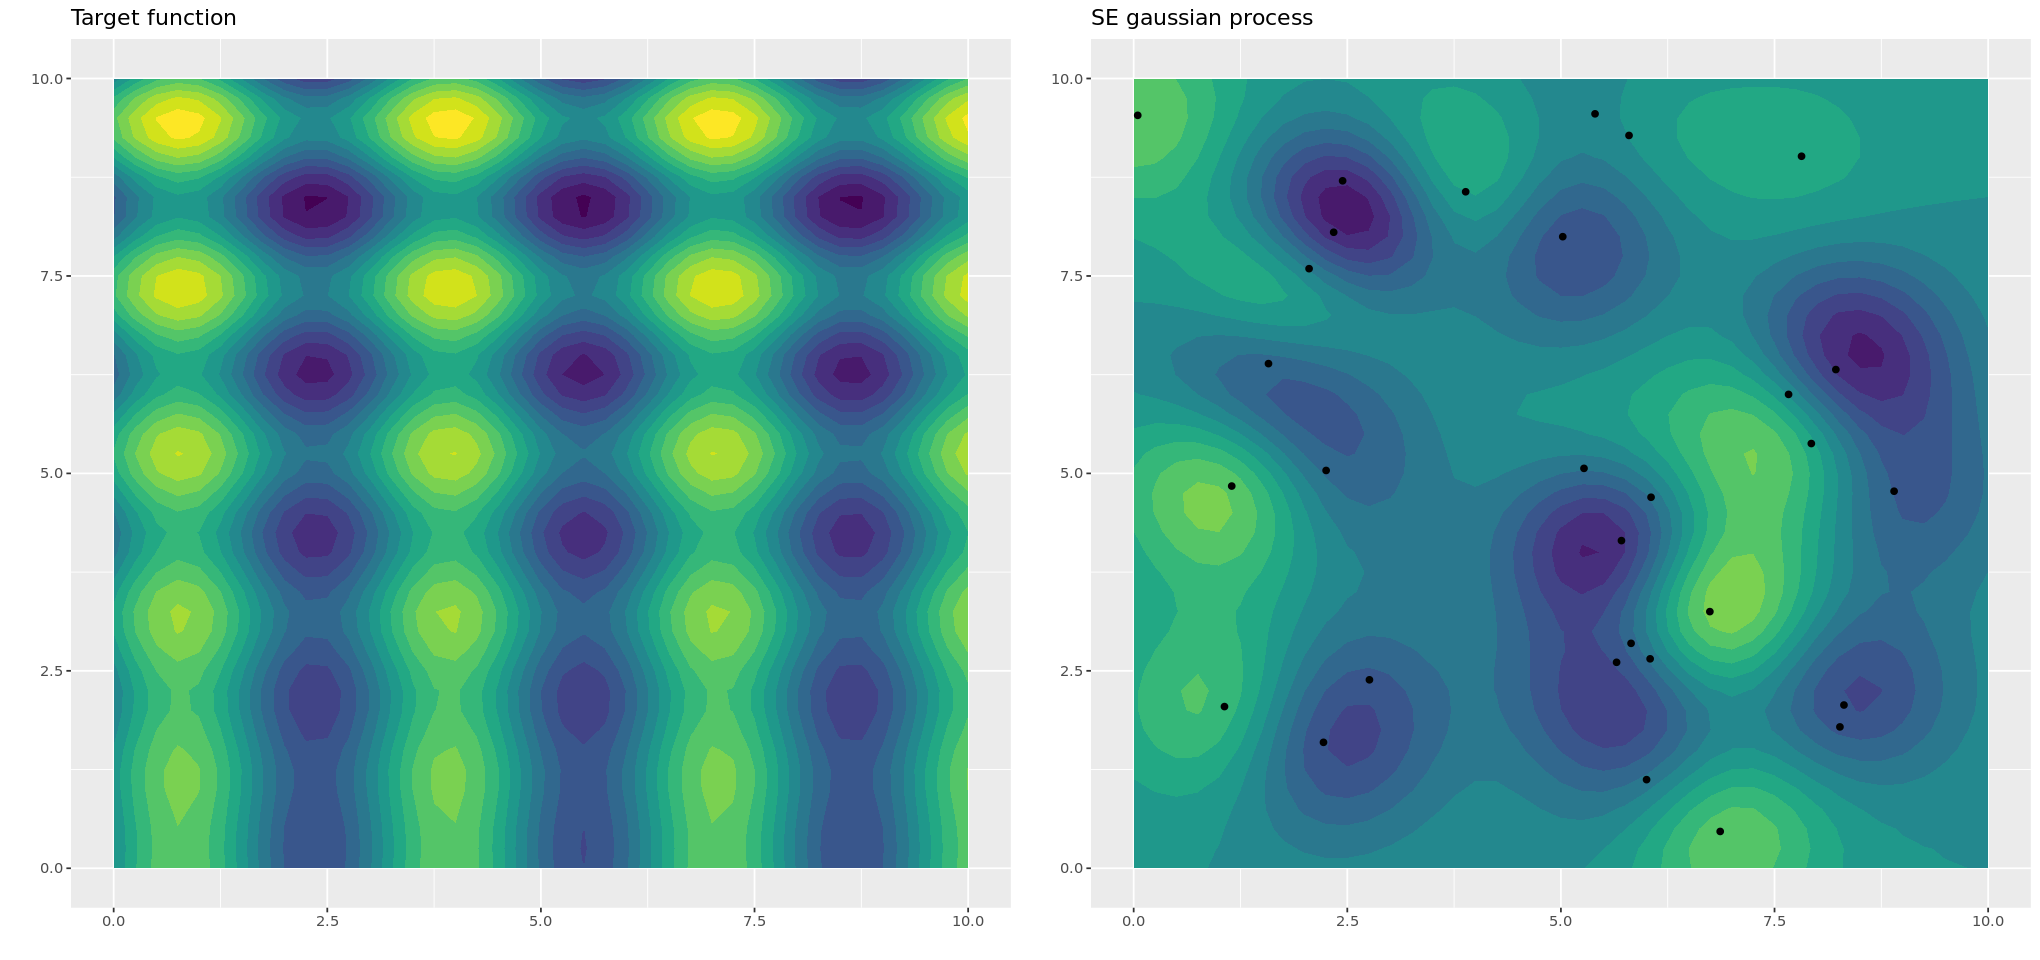

In [406]:
# Plot SE-GP with fitted hyperparameters

n.plot.train.points <- 30
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, 0, 10), x2=runif(n.plot.train.points, 0, 10))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('se', l.se, sigma2.se))
titles <- list('SE gaussian process')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    gp.model <- calculate.regression.model(observed.x, observed.y, k)

    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=8)
plt2 <- plot_grid(plotlist=plots, ncol=2, align='h')
print(plt2)

# Additive kernel optimization

In [396]:
set.seed(123)
kernel.type <- 'ak'
optim.params <- get.init.params(kernel.type)

optim.result <- optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        temp=1000,
                        tmax=1000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')
cat(paste0(' Variance: ', 
           paste0(formatC(optim.result$par[3:4]*100/sum(optim.result$par[3:4]), 
                          format='f', digits=2), '%', collapse = ', '), 
         sep='\n'))

l.ak <- optim.result$par[1:2]
sigma2.ak <- optim.result$par[3:4]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”
l=2,2, sigma2=2,2 (mse=4.56534753843939)
l=2.001,2, sigma2=2,2 (mse=4.0404852377164)
l=1.999,2, sigma2=2,2 (mse=4.04999230976392)
l=2,2.001, sigma2=2,2 (mse=4.06118747125164)
l=2,1.999, sigma2=2,2 (mse=4.02930113774762)
l=2,2, sigma2=2.001,2 (mse=4.04465363219714)
l=2,2, sigma2=1.999,2 (mse=4.04584066803739)
l=2,2, sigma2=2,2.001 (mse=4.04631220167796)
l=2,2, sigma2=2,1.999 (mse=4.04418148354909)
l=6.75353602376271,0.01, sigma2=2.59351792012485,0.934640935563501 (mse=0.732308841921667)
l=6.75453602376271,0.01, sigma2=2.59351792012485,0.934640935563501 (mse=0.732316757416713)
l=6.75253602376271,0.01, sigma2=2.59351792012485,0.934640935563501 (mse=0.732300923403583)
l=6.75353602376271,0.011, sigma2=2.59351792012485,0.934640935563501 (mse=0.739513671976063)
l=6.75353602376271,0.01, sigma2=2.59351792012485,0.934640935563501 (mse=0.7

l=1.01865303782322,0.01, sigma2=0.216222469149066,7.00420907559832 (mse=0.557615371531568)
l=1.01865303782322,0.01, sigma2=0.217222469149066,7.00520907559832 (mse=0.557315043964192)
l=1.01865303782322,0.01, sigma2=0.217222469149066,7.00320907559832 (mse=0.557295837793955)
l=0.940501374551641,0.01, sigma2=0.184842166163723,7.08691546154149 (mse=0.554553581755314)
l=0.941501374551641,0.01, sigma2=0.184842166163723,7.08691546154149 (mse=0.554730847904653)
l=0.939501374551641,0.01, sigma2=0.184842166163723,7.08691546154149 (mse=0.554376337468739)
l=0.940501374551641,0.011, sigma2=0.184842166163723,7.08691546154149 (mse=0.553516428047853)
l=0.940501374551641,0.01, sigma2=0.184842166163723,7.08691546154149 (mse=0.554553581755314)
l=0.940501374551641,0.01, sigma2=0.185842166163723,7.08691546154149 (mse=0.554181775612693)
l=0.940501374551641,0.01, sigma2=0.183842166163723,7.08691546154149 (mse=0.554926152687674)
l=0.940501374551641,0.01, sigma2=0.184842166163723,7.08791546154149 (mse=0.5545632

l=1.6897944123592,1.16510914495775, sigma2=1.11205338104645,5.87445336131876 (mse=0.0285557688716618)
l=1.52294767521376,1.17035482883766, sigma2=1.16138925532181,5.97024137666566 (mse=0.0233037439904592)
l=1.52394767521376,1.17035482883766, sigma2=1.16138925532181,5.97024137666566 (mse=0.0232626754840637)
l=1.52194767521376,1.17035482883766, sigma2=1.16138925532181,5.97024137666566 (mse=0.0233457468369767)
l=1.52294767521376,1.17135482883766, sigma2=1.16138925532181,5.97024137666566 (mse=0.0233548716532779)
l=1.52294767521376,1.16935482883766, sigma2=1.16138925532181,5.97024137666566 (mse=0.0232542027913633)
l=1.52294767521376,1.17035482883766, sigma2=1.16238925532181,5.97024137666566 (mse=0.0232894845902782)
l=1.52294767521376,1.17035482883766, sigma2=1.16038925532181,5.97024137666566 (mse=0.0233180172891633)
l=1.52294767521376,1.17035482883766, sigma2=1.16138925532181,5.97124137666566 (mse=0.0233065103757675)
l=1.52294767521376,1.17035482883766, sigma2=1.16138925532181,5.96924137666

l=1.50707377646391,1.02651548202495, sigma2=6.5380093499771,2.37691585257328 (mse=0.000901469750804233)
l=1.50707377646391,1.02651548202495, sigma2=6.5380093499771,2.37491585257328 (mse=0.000900310695205877)
l=1.52188912675239,0.971689299334073, sigma2=8.26354855922718,1.1701343767529 (mse=0.000292610912204354)
l=1.52288912675239,0.971689299334073, sigma2=8.26354855922718,1.1701343767529 (mse=0.000293343356433545)
l=1.52088912675239,0.971689299334073, sigma2=8.26354855922718,1.1701343767529 (mse=0.000291894605170186)
l=1.52188912675239,0.972689299334073, sigma2=8.26354855922718,1.1701343767529 (mse=0.000291398091453757)
l=1.52188912675239,0.970689299334073, sigma2=8.26354855922718,1.1701343767529 (mse=0.000293847063735071)
l=1.52188912675239,0.971689299334073, sigma2=8.26454855922718,1.1701343767529 (mse=0.000292564053708843)
l=1.52188912675239,0.971689299334073, sigma2=8.26254855922718,1.1701343767529 (mse=0.000292657783757697)
l=1.52188912675239,0.971689299334073, sigma2=8.2635485592

l=1.58095500618967,0.889782873448921, sigma2=9.88576521864309,0 (mse=1.87319473807254e-07)
l=1.58095500618967,0.890782873448921, sigma2=9.88676521864308,0 (mse=1.87951547073807e-07)
l=1.58095500618967,0.890782873448921, sigma2=9.88476521864309,0 (mse=1.87974046513889e-07)
l=1.58095500618967,0.890782873448921, sigma2=9.88576521864309,0.001 (mse=1.97294759962141e-06)
l=1.58095500618967,0.890782873448921, sigma2=9.88576521864309,0 (mse=1.87959940556438e-07)
l=1.71275826294838,0.809622575184422, sigma2=10,0 (mse=1.64883374994523e-07)
l=1.71375826294838,0.809622575184422, sigma2=10,0 (mse=1.65603497755225e-07)
l=1.71175826294838,0.809622575184422, sigma2=10,0 (mse=1.6416143732175e-07)
l=1.71275826294838,0.810622575184422, sigma2=10,0 (mse=1.65164626182579e-07)
l=1.71275826294838,0.808622575184422, sigma2=10,0 (mse=1.64596596253994e-07)
l=1.71275826294838,0.809622575184422, sigma2=10,0 (mse=1.64883374994523e-07)
l=1.71275826294838,0.809622575184422, sigma2=9.999,0 (mse=1.64891529564015e-07)



Optimization results:
 Params=1.67673176458089,0.831801175511052,9.96877936577408,0
 Performance=1.55766781439459e-07
 Variance: 100.00%, 0.00%


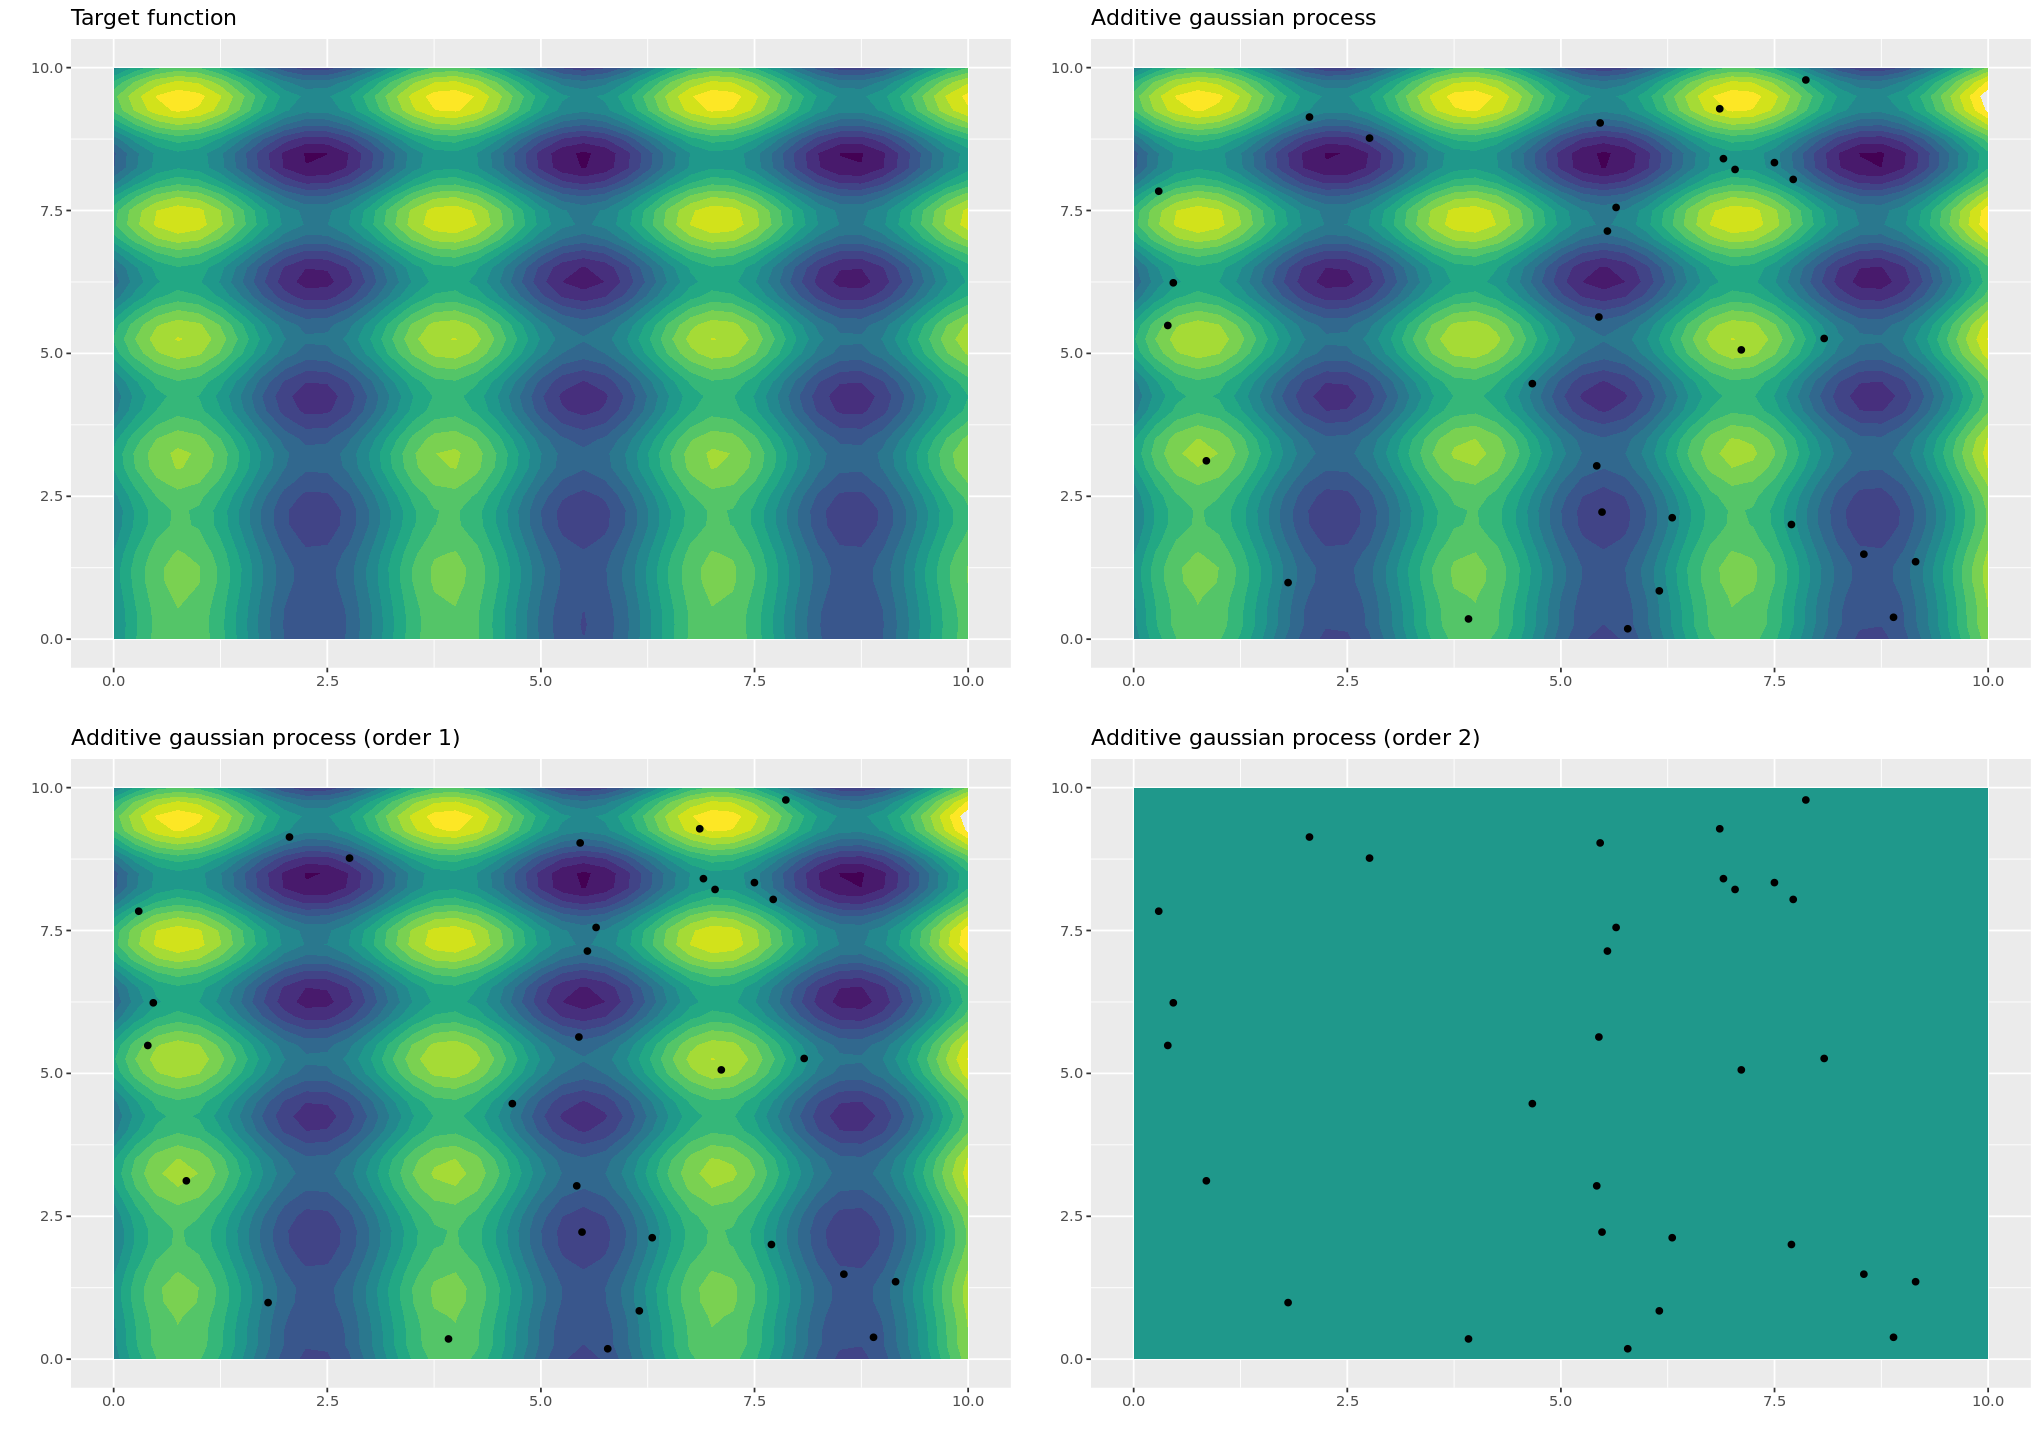

In [407]:
# Plot AK-GP with fitted hyperparameters

l.ak.plot <- l.ak
sigma2.ak.plot <- sigma2.ak
n.plot.train.points <- 30
set.seed(2241)

observed.x <- data.frame(x1=runif(n.plot.train.points, 0, 10), x2=runif(n.plot.train.points, 0, 10))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('ak', l.ak.plot, sigma2.ak.plot),
                build.k('ak1', l.ak.plot, sigma2.ak.plot),
                build.k('ak2', l.ak.plot, sigma2.ak.plot))
titles <- list('Additive gaussian process', 'Additive gaussian process (order 1)', 'Additive gaussian process (order 2)')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    gp.model <- calculate.regression.model(observed.x, observed.y, k)

    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

options(repr.plot.width=17, repr.plot.height=12)
plt2 <- plot_grid(plotlist=plots, ncol=2, align='h')
print(plt2)

# Orthogonal additive kernel optimization

In [408]:
set.seed(123)
kernel.type <- 'oak.gaussian'
optim.params <- get.init.params(kernel.type)

optim.result <- optim(par=optim.params$initial.pars,
                      method='SAN',
                      #method='L-BFGS-B',
                      fn=calculate.params.ll,
                      lower=optim.params$lower.bounds,
                      upper=optim.params$upper.bounds,
                      control=list(
                        pgtol=0,
                        fnscale=fnscale,
                        temp=10000,
                        tmax=10000,
                        maxit=10000
                        ),
                      kernel.type=kernel.type
                      )
cat('\nOptimization results:', sep='\n')
cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
cat(paste0(' Performance=', optim.result$value), sep='\n')
cat(paste0(' Variance: ', 
           paste0(formatC(optim.result$par[3:5]*100/sum(optim.result$par[3:5]), 
                          format='f', digits=2), '%', collapse = ', '), 
         sep='\n'))

l.oak.gaussian <- optim.result$par[1:2]
sigma2.oak.gaussian <- optim.result$par[3:5]

Warning message in optim(par = optim.params$initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”
l=5,4, sigma2=3,2,1 (mse=145.564527488047)
l=5.001,4, sigma2=3,2,1 (mse=0.63197447684156)
l=4.999,4, sigma2=3,2,1 (mse=0.629144774019744)
l=5,4.001, sigma2=3,2,1 (mse=0.632266954510669)
l=5,3.999, sigma2=3,2,1 (mse=0.628854304906218)
l=5,4, sigma2=3.001,2,1 (mse=0.630553985610897)
l=5,4, sigma2=2.999,2,1 (mse=0.630556265191317)
l=5,4, sigma2=3,2.001,1 (mse=0.630394675105517)
l=5,4, sigma2=3,1.999,1 (mse=0.63071569426057)
l=5,4, sigma2=3,2,1.001 (mse=0.629962273392414)
l=5,4, sigma2=3,2,0.999 (mse=0.631150352238129)
l=3.58514858909203,2.29367519777423, sigma2=3.00113979021044,2.1605095775265,1.59403942285735 (mse=0.732953410488677)
l=3.58614858909203,2.29367519777423, sigma2=3.00113979021044,2.1605095775265,1.59403942285735 (mse=0.73213366626305)
l=3.58414858909203,2.29367519777423, sigma2=3.00113979021044,2.1605095775265,1.59403

l=3.4157964587691,0.00999999999999979, sigma2=3.00264914677253,2.07423069335059,1.87128088979546 (mse=0.690829639392548)
l=3.4157964587691,0.00999999999999979, sigma2=3.00264914677253,2.07523069335059,1.87228088979546 (mse=0.690828151562558)
l=3.4157964587691,0.00999999999999979, sigma2=3.00264914677253,2.07523069335059,1.87028088979546 (mse=0.690858390435579)
l=1.88258026726793,0.00999999999999979, sigma2=3.00261532749519,1.33099244784057,2.70298919270522 (mse=0.573731915058976)
l=1.88358026726793,0.00999999999999979, sigma2=3.00261532749519,1.33099244784057,2.70298919270522 (mse=0.573987997604055)
l=1.88158026726793,0.00999999999999979, sigma2=3.00261532749519,1.33099244784057,2.70298919270522 (mse=0.573475087704718)
l=1.88258026726793,0.0109999999999998, sigma2=3.00261532749519,1.33099244784057,2.70298919270522 (mse=0.573159678444161)
l=1.88258026726793,0.01, sigma2=3.00261532749519,1.33099244784057,2.70298919270522 (mse=0.573731915058975)
l=1.88258026726793,0.00999999999999979, sig

l=2.24246825329093,0.575081590085207, sigma2=3.00249200168346,1.41974263136393,2.51622294022389 (mse=0.0462236946303724)
l=2.24346825329093,0.575081590085207, sigma2=3.00249200168346,1.41974263136393,2.51622294022389 (mse=0.0465823048793676)
l=2.24146825329093,0.575081590085207, sigma2=3.00249200168346,1.41974263136393,2.51622294022389 (mse=0.0458677614905182)
l=2.24246825329093,0.576081590085207, sigma2=3.00249200168346,1.41974263136393,2.51622294022389 (mse=0.0459982788071171)
l=2.24246825329093,0.574081590085207, sigma2=3.00249200168346,1.41974263136393,2.51622294022389 (mse=0.0464500727885943)
l=2.24246825329093,0.575081590085207, sigma2=3.00349200168346,1.41974263136393,2.51622294022389 (mse=0.0462236377520967)
l=2.24246825329093,0.575081590085207, sigma2=3.00149200168346,1.41974263136393,2.51622294022389 (mse=0.0462237515281023)
l=2.24246825329093,0.575081590085207, sigma2=3.00249200168346,1.42074263136393,2.51622294022389 (mse=0.0461893865909152)
l=2.24246825329093,0.57508159008

l=2.16662838117507,0.638554743677746, sigma2=3.00248211622492,1.39396818728965,2.54929920021084 (mse=0.0258887361496603)
l=2.16662838117507,0.636554743677746, sigma2=3.00248211622492,1.39396818728965,2.54929920021084 (mse=0.0259160517347231)
l=2.16662838117507,0.637554743677746, sigma2=3.00348211622492,1.39396818728965,2.54929920021084 (mse=0.0259001893782908)
l=2.16662838117507,0.637554743677746, sigma2=3.00148211622492,1.39396818728965,2.54929920021084 (mse=0.0259001789604716)
l=2.16662838117507,0.637554743677746, sigma2=3.00248211622492,1.39496818728965,2.54929920021084 (mse=0.0258842164881223)
l=2.16662838117507,0.637554743677746, sigma2=3.00248211622492,1.39296818728965,2.54929920021084 (mse=0.0259162230067972)
l=2.16662838117507,0.637554743677746, sigma2=3.00248211622492,1.39396818728965,2.55029920021084 (mse=0.025909253361426)
l=2.16662838117507,0.637554743677746, sigma2=3.00248211622492,1.39396818728965,2.54829920021084 (mse=0.025891130152573)
l=2.13723751846713,0.6588277168028

l=1.96635402520859,0.755358845172697, sigma2=3.00318323053674,1.38212079661684,2.59999345899408 (mse=0.0166410444409252)
l=1.96635402520859,0.755358845172697, sigma2=3.00118323053674,1.38212079661684,2.59999345899408 (mse=0.0166409910169718)
l=1.96635402520859,0.755358845172697, sigma2=3.00218323053674,1.38312079661684,2.59999345899408 (mse=0.0166397837767017)
l=1.96635402520859,0.755358845172697, sigma2=3.00218323053674,1.38112079661684,2.59999345899408 (mse=0.0166426647720933)
l=1.96635402520859,0.755358845172697, sigma2=3.00218323053674,1.38212079661684,2.60099345899408 (mse=0.0166420749229272)
l=1.96635402520859,0.755358845172697, sigma2=3.00218323053674,1.38212079661684,2.59899345899408 (mse=0.0166400817276486)
l=1.96346931614391,0.756954696735499, sigma2=3.00216701878921,1.38274762881983,2.6001108874789 (mse=0.016638556362835)
l=1.96446931614391,0.756954696735499, sigma2=3.00216701878921,1.38274762881983,2.6001108874789 (mse=0.0166421768151258)
l=1.96246931614391,0.75695469673549

l=1.97714338835448,0.757189309735964, sigma2=3.00079308038788,1.42767933626642,2.55789095746378 (mse=0.0166132752878374)
l=1.97714338835448,0.757189309735964, sigma2=3.00079308038788,1.42867933626642,2.55889095746378 (mse=0.0166136760973661)
l=1.97714338835448,0.757189309735964, sigma2=3.00079308038788,1.42867933626642,2.55689095746378 (mse=0.0166139420326997)
l=1.98626445405203,0.753383750298194, sigma2=3.00057162119745,1.43555306942777,2.54982966416314 (mse=0.0166175480416048)
l=1.98726445405203,0.753383750298194, sigma2=3.00057162119745,1.43555306942777,2.54982966416314 (mse=0.0166284360185792)
l=1.98526445405203,0.753383750298194, sigma2=3.00057162119745,1.43555306942777,2.54982966416314 (mse=0.0166148987661529)
l=1.98626445405203,0.754383750298194, sigma2=3.00057162119745,1.43555306942777,2.54982966416314 (mse=0.0166368204608335)
l=1.98626445405203,0.752383750298194, sigma2=3.00057162119745,1.43555306942777,2.54982966416314 (mse=0.0166181908854925)
l=1.98626445405203,0.75338375029

l=1.98106855282079,0.753381895614694, sigma2=2.99839415020109,1.41120732384399,2.54382079888142 (mse=0.0166107318272007)
l=1.98206855282079,0.753381895614694, sigma2=2.99839415020109,1.41120732384399,2.54382079888142 (mse=0.0166122592854511)
l=1.98006855282079,0.753381895614694, sigma2=2.99839415020109,1.41120732384399,2.54382079888142 (mse=0.0166174668947653)
l=1.98106855282079,0.754381895614694, sigma2=2.99839415020109,1.41120732384399,2.54382079888142 (mse=0.0166153722708985)
l=1.98106855282079,0.752381895614694, sigma2=2.99839415020109,1.41120732384399,2.54382079888142 (mse=0.016625724100779)
l=1.98106855282079,0.753381895614694, sigma2=2.99939415020109,1.41120732384399,2.54382079888142 (mse=0.0166107574873167)
l=1.98106855282079,0.753381895614694, sigma2=2.99739415020109,1.41120732384399,2.54382079888142 (mse=0.0166107061439872)
l=1.98106855282079,0.753381895614694, sigma2=2.99839415020109,1.41220732384399,2.54382079888142 (mse=0.0166114305498539)
l=1.98106855282079,0.753381895614

l=2.06341547310105,0.728231208402222, sigma2=2.79587441092681,0.705793529216514,0.976676844604286 (mse=0.0180805979609193)
l=2.06441547310105,0.729231208402222, sigma2=2.79587441092681,0.705793529216514,0.976676844604286 (mse=0.0177683662956867)
l=2.06441547310105,0.727231208402222, sigma2=2.79587441092681,0.705793529216514,0.976676844604286 (mse=0.018126915584091)
l=2.06441547310105,0.728231208402222, sigma2=2.79687441092681,0.705793529216514,0.976676844604286 (mse=0.0179430297340332)
l=2.06441547310105,0.728231208402222, sigma2=2.79487441092681,0.705793529216514,0.976676844604286 (mse=0.017943006136854)
l=2.06441547310105,0.728231208402222, sigma2=2.79587441092681,0.706793529216514,0.976676844604286 (mse=0.0179884261117646)
l=2.06441547310105,0.728231208402222, sigma2=2.79587441092681,0.704793529216514,0.976676844604286 (mse=0.0178981528789049)
l=2.06441547310105,0.728231208402222, sigma2=2.79587441092681,0.705793529216514,0.977676844604286 (mse=0.0179109606773055)
l=2.06441547310105

l=2.04378432084219,0.753784043605935, sigma2=2.73354670391032,0.407787316762952,0.547283809020945 (mse=0.0170954124977377)
l=2.04378432084219,0.754784043605935, sigma2=2.73454670391032,0.407787316762952,0.547283809020945 (mse=0.0169120226300834)
l=2.04378432084219,0.754784043605935, sigma2=2.73254670391032,0.407787316762952,0.547283809020945 (mse=0.0169120099732753)
l=2.04378432084219,0.754784043605935, sigma2=2.73354670391032,0.408787316762952,0.547283809020945 (mse=0.0170007131684331)
l=2.04378432084219,0.754784043605935, sigma2=2.73354670391032,0.406787316762952,0.547283809020945 (mse=0.016824985532749)
l=2.04378432084219,0.754784043605935, sigma2=2.73354670391032,0.407787316762952,0.548283809020945 (mse=0.0168480069575429)
l=2.04378432084219,0.754784043605935, sigma2=2.73354670391032,0.407787316762952,0.546283809020945 (mse=0.0169772676827376)
l=2.04359732230403,0.7451902823294, sigma2=2.78679900152007,0.62866420318894,0.93602658679692 (mse=0.0159846008465508)
l=2.04459732230403,0.

l=1.95781145616447,0.72415106672364, sigma2=2.65409988662106,0.0422335503856104,0 (mse=3.74320594754719e-05)
l=1.95881145616447,0.72515106672364, sigma2=2.65409988662106,0.0422335503856104,0 (mse=3.82713661067674e-05)
l=1.95881145616447,0.72315106672364, sigma2=2.65409988662106,0.0422335503856104,0 (mse=3.77070436467461e-05)
l=1.95881145616447,0.72415106672364, sigma2=2.65509988662106,0.0422335503856104,0 (mse=3.79851814162822e-05)
l=1.95881145616447,0.72415106672364, sigma2=2.65309988662106,0.0422335503856104,0 (mse=3.798519972568e-05)
l=1.95881145616447,0.72415106672364, sigma2=2.65409988662106,0.0432335503856104,0 (mse=3.70231539647384e-05)
l=1.95881145616447,0.72415106672364, sigma2=2.65409988662106,0.0412335503856104,0 (mse=3.89937714226658e-05)
l=1.95881145616447,0.72415106672364, sigma2=2.65409988662106,0.0422335503856104,0.001 (mse=0.0111365260722634)
l=1.95881145616447,0.72415106672364, sigma2=2.65409988662106,0.0422335503856104,0 (mse=3.79852128225015e-05)
l=1.95461692467666,

l=1.89415239363771,0.677525171296039, sigma2=2.65409783252363,0.219931463755928,0 (mse=2.37540821920203e-06)
l=1.89215239363771,0.677525171296039, sigma2=2.65409783252363,0.219931463755928,0 (mse=2.32308677256112e-06)
l=1.89315239363771,0.678525171296039, sigma2=2.65409783252363,0.219931463755928,0 (mse=2.34810709630693e-06)
l=1.89315239363771,0.676525171296039, sigma2=2.65409783252363,0.219931463755928,0 (mse=2.35026228706849e-06)
l=1.89315239363771,0.677525171296039, sigma2=2.65509783252363,0.219931463755928,0 (mse=2.34903656680226e-06)
l=1.89315239363771,0.677525171296039, sigma2=2.65309783252363,0.219931463755928,0 (mse=2.34902907037206e-06)
l=1.89315239363771,0.677525171296039, sigma2=2.65409783252363,0.220931463755928,0 (mse=2.34052523688894e-06)
l=1.89315239363771,0.677525171296039, sigma2=2.65409783252363,0.218931463755928,0 (mse=2.35764336037021e-06)
l=1.89315239363771,0.677525171296039, sigma2=2.65409783252363,0.219931463755928,0.001 (mse=0.000443438014564373)
l=1.89315239363


Optimization results:
 Params=1.73572515286338,0.56573278622944,2.65409290752181,0.64598819890982,0
 Performance=1.71843197407711e-07
 Variance: 80.43%, 19.57%, 0.00%


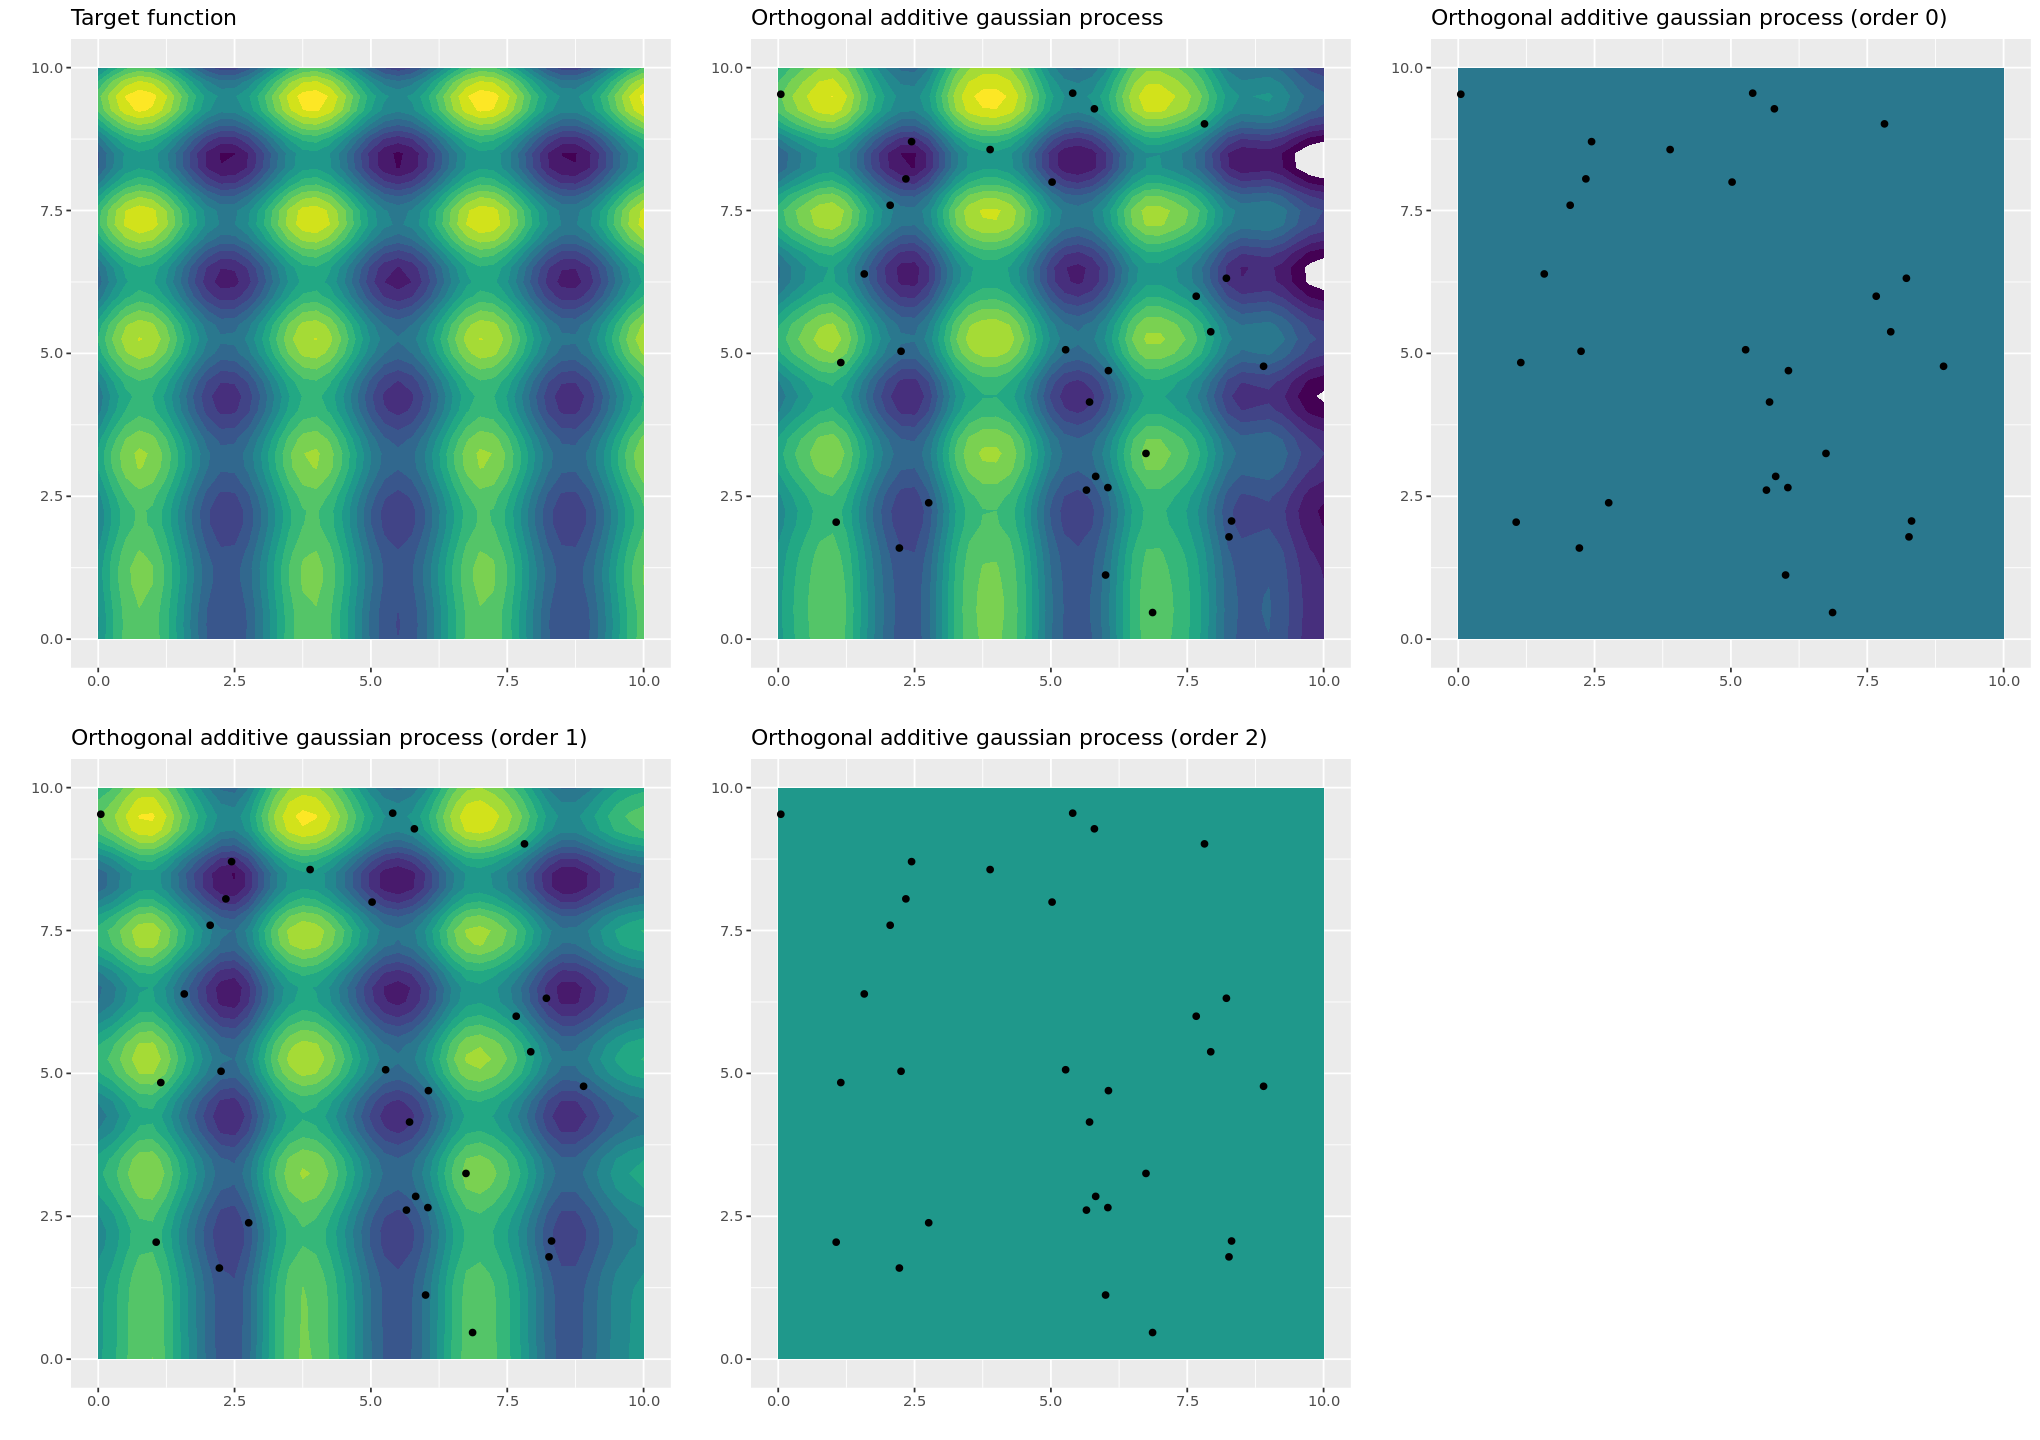

In [414]:
# Plot OAK-GP with fitted hyperparameters

l.oak.gaussian.plot <- l.oak.gaussian
sigma2.oak.gaussian.plot <- sigma2.oak.gaussian
n.plot.train.points <- 30
set.seed(221)

observed.x <- data.frame(x1=runif(n.plot.train.points, 0, 10), x2=runif(n.plot.train.points, 0, 10))
observed.y <- apply(observed.x, 1, f)

kernels <- list(build.k('oak.gaussian', l.oak.gaussian.plot, sigma2.oak.gaussian.plot),
                build.k('oak.gaussian0', l.oak.gaussian.plot, sigma2.oak.gaussian.plot), 
                build.k('oak.gaussian1', l.oak.gaussian.plot, sigma2.oak.gaussian.plot), 
                build.k('oak.gaussian2', l.oak.gaussian.plot, sigma2.oak.gaussian.plot))
titles <- list('Orthogonal additive gaussian process', 
               'Orthogonal additive gaussian process (order 0)', 
               'Orthogonal additive gaussian process (order 1)', 
               'Orthogonal additive gaussian process (order 2)')

plots <- list(plt.f)
for(i in seq_along(kernels)) {
    k <- kernels[[i]]
    title <- titles[[i]]
    
    gp.model <- calculate.regression.model(observed.x, observed.y, k)
    
    df.f.model <- df.f
    df.f.model$z <- gp.model$mean(xx)

    plt <- ggplot(df.f.model, aes(x=x, y=y, z=z)) +
      geom_contour_filled(
        breaks=color.breaks
      ) +
      geom_point(data=observed.x, aes(x=x1, y=x2, z=NULL)) +
      scale_fill_viridis_d(drop=FALSE) +
      theme(legend.position = "none") +
      xlab('') +
      ylab('') +
      ggtitle(title)
    plots <- append(plots, list(plt))
}

plt2 <- plot_grid(plotlist=plots, ncol=3, align='h')
print(plt2)

# Confidence intervals for hyperparameters

In [351]:
# CI for different seeds

par.list <- list(
    ak=c('l1', 'l2', 'sigma1', 'sigma2', 'mse'),
    oak.gaussian=c('l1', 'l2', 'sigma1', 'sigma2', 'sigma3', 'mse')
    )

df.result <- list()
for(kernel.type in c('ak', 'oak.gaussian')) {
    df.result[[kernel.type]] <- data.frame()
    for(seed in seq(50)) {
        set.seed(seed+12)
        optim.params <- get.init.params(kernel.type)
        rand.initial.pars <- sapply(seq(length(par.list[[kernel.type]])-1), 
                                    function(i) runif(1, optim.params$lower.bounds[i], optim.params$upper.bounds[i]))
                                    
        optim.result <- optim(par=rand.initial.pars,
                              method='SAN',
                              #method='L-BFGS-B',
                              fn=calculate.params.ll,
                              lower=optim.params$lower.bounds,
                              upper=optim.params$upper.bounds,
                              control=list(
                                pgtol=0,
                                fnscale=fnscale,
                                temp=1000,
                                tmax=1000,
                                maxit=10000
                                ),
                              kernel.type=kernel.type,
                              verbose=FALSE
                              )
        cat('\nOptimization results:', sep='\n')
        cat(paste0(' Params=', paste0(optim.result$par, collapse=',')), sep='\n')
        cat(paste0(' Performance=', optim.result$value), sep='\n')
        if (kernel.type == 'ak') {
          cat(paste0(' Variance: ', 
                       paste0(formatC(optim.result$par[3:4]*100/sum(optim.result$par[3:4]), 
                                      format='f', digits=2), '%', collapse = ', '), 
                     sep='\n'))

          l <- optim.result$par[1:2]
          sigma2 <- optim.result$par[3:4]
        } else if (kernel.type == 'oak.gaussian') {
          cat(paste0(' Variance: ', 
                       paste0(formatC(optim.result$par[3:5]*100/sum(optim.result$par[3:5]), 
                                      format='f', digits=2), '%', collapse = ', '), 
                     sep='\n'))

          l <- optim.result$par[1:2]
          sigma2 <- optim.result$par[3:5]
        } else if (kernel.type == 'se') {
          l <- optim.result$par[1]
          sigma2 <- optim.result$par[2]
        }  
        df.result[[kernel.type]] <- rbind(df.result[[kernel.type]], c(kernel.type, optim.result$par, optim.result$value))
    }
    names(df.result[[kernel.type]]) <- c('kernel.type', par.list[[kernel.type]])
}

print(df.result)

Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.366732911853963,1.32201663392698,5.02090612424513,0
 Performance=4.34180013420067e-07
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.50739344193334,4.7653847557334,0.904492440293862,10
 Performance=0.434704122115089
 Variance: 8.29%, 91.71%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.20209988916494,9.99999377322002,0.0016568840513744,0
 Performance=0.16958109211886
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.92889601242906,3.42417317023478,5.67763958968517,0
 Performance=0.126873978649271
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.88589864121026,10,8.33003025203074,0
 Performance=0.179163639223627
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.230734184701,7.10489375830162,9.65834765927866,0.78610778786242
 Performance=1.00771172319677
 Variance: 92.47%, 7.53%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.81894010012235,10,0.0438483284119762,0
 Performance=0.596497370959748
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.77643867309671,7.68764675431652,2.78963138349354,5.29163692612201
 Performance=1.11778478732376
 Variance: 34.52%, 65.48%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.52797658373795,2.14139385355493,7.28967872940766,-2.22044604925031e-16
 Performance=0.00474816135435609
 Variance: 100.00%, -0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.50740804826492,4.76526779607328,0.902716213860178,10
 Performance=0.434704097854458
 Variance: 8.28%, 91.72%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.47297007163861,4.70129164679882,0.792684819691443,8.33584443588844
 Performance=0.434880449919901
 Variance: 8.68%, 91.32%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.11618154027037,1.23099771848008,10,0
 Performance=1.09402677827276e-08
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.808886118763,7.0489681247485,0,10
 Performance=0.488223066891477
 Variance: 0.00%, 100.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.11828704352131,0.613115014228375,10,0
 Performance=2.65375166996992e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.52318956320065,0.609491839661495,5.57940963285694,0
 Performance=8.86070823107007e-10
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.80821669898645,1.23108138885675,10,0
 Performance=9.7079617588375e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.70223751338882,1.22280355866034,10,0
 Performance=6.73267518174096e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.9999973335724,7.65253958686342,0.00345757190651008,0
 Performance=0.600679789983108
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.82948177344342,10,5.24187350661753,0
 Performance=0.178453517041802
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.50744097666171,4.76528902320808,0.900659613992299,10
 Performance=0.43470412381464
 Variance: 8.26%, 91.74%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.93010187160145,3.37321423370399,4.58791773843737,0
 Performance=0.126289278630974
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.45323772020638,9.98541863150662,8.8489399291575,2.38425959367305
 Performance=0.601597306889376
 Variance: 78.77%, 21.23%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.781605068560699,0.606046123350792,10,0
 Performance=3.22006790285178e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.22755285023944,6.75823077327572,8.02289951127023,2.60308288270608
 Performance=1.25499838164464
 Variance: 75.50%, 24.50%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.50744548859059,4.76511304338608,0.899250901410964,10
 Performance=0.434704132993048
 Variance: 8.25%, 91.75%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.948638314505141,0.609861371007079,6.64996088232909,0
 Performance=1.05478307677379e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.478681800407,1.29342603495333,1.89497692041772,0
 Performance=3.61526609329146e-08
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.83898434948409,8.73030876998091,6.90117288148031,1.1593607836403
 Performance=0.823554278290791
 Variance: 85.62%, 14.38%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.03090775033069,10,0.000856829477174215,0
 Performance=0.168560591298674
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.81913386819692,10,0.0438574127782704,-8.88178419700125e-16
 Performance=0.596497371256064
 Variance: 100.00%, -0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.85552644197596,9.10855269515654,0.576738903764635,7.05398411257192
 Performance=1.12055171818188
 Variance: 7.56%, 92.44%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.84927718249368,0.419951124761147,0
 Performance=0.503662575698471
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.33739437160781,3.18219111481914,2.40921848919243,3.7841412727721
 Performance=1.91731665142649
 Variance: 38.90%, 61.10%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.651280038965938,0.555123029027793,6.55484891848534,0
 Performance=2.74374316677687e-08
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.76985036968486,3.74542129484238,7.61502029839903,8.22491610888392
 Performance=1.25216506728848
 Variance: 48.07%, 51.93%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.15570796191876,0.624665005746737,9.13730831550077,0
 Performance=5.14027494398701e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.50741599615496,4.76522162890981,0.903848097540436,10
 Performance=0.43470413415188
 Variance: 8.29%, 91.71%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.99972712496098,1.08855533550393,0.00221369835296413,0
 Performance=0.509619012134997
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.37153638511838,9.99985984310218,0.00376984334554486,0
 Performance=0.171935474961041
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.78796706570103,9.93155563949359,3.39689141050548,0
 Performance=0.177979377975151
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.23469183837187,0.606589164628594,10,0
 Performance=3.14392813342003e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,10,6.73173630353199,0
 Performance=0.644235262036537
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.52928844320884,0.981517993859968,10,0
 Performance=2.65600482459092e-07
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.47545152099909,4.70652337782682,0.809030112059832,8.44960513900617
 Performance=0.434867175700192
 Variance: 8.74%, 91.26%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.44670430934057,5.1343658608757,0.386284298729151,1.66176579194143
 Performance=1.04202716063441
 Variance: 18.86%, 81.14%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.827063099389416,0.589841418089486,9.9999999999962,0
 Performance=3.31682258705194e-10
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.30085209417513,0.597173527321388,10,0
 Performance=1.05088389820222e-09
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,3.58201714133254,7.55592006852869,0
 Performance=0.597946524424806
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.83548015674922,10,2.87855178914942,0
 Performance=0.177811537306585
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.99888074541121,1.08395815077947,0.00194533909310107,0
 Performance=0.509459707559073
 Variance: 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.13165454941214,3.90482961998072,4.01147817343946,9.24833313388667
 Performance=2.39269331596229e-05
 Variance: 22.75%, 23.37%, 53.88%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.07140699136292,9.27215102174439,9.56515449451572,4.18056949666786,9.96727785751352
 Performance=0.31716853060595
 Variance: 40.34%, 17.63%, 42.03%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.25807560367112,9.61297331116871,10,2.42554197400218
 Performance=1.30919257082808e-05
 Variance: 43.62%, 45.38%, 11.01%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.63248506122079,1.09095370418178,4.49995505239328,0,8.51424023808384
 Performance=0.000383529990613108
 Variance: 34.58%, 0.00%, 65.42%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.86124942277442,10,5.02099078899004,7.91932105156211,0
 Performance=0.178862307692794
 Variance: 38.80%, 61.20%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.1051619111122,7.957078111057,9.65818134140586,0.653844406504341,0
 Performance=0.618114999590664
 Variance: 93.66%, 6.34%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.91499403730094,10,6.50545755655455,9.9214450124712,0
 Performance=0.615858052333288
 Variance: 39.60%, 60.40%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=6.51308259118965,9.91326166488636,0.796186969269832,0.135743382541244,9.19201321097939
 Performance=0.529144459533225
 Variance: 7.86%, 1.34%, 90.79%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.13181438478324,7.00496862172779,4.28115753760996,9.23365045217114
 Performance=2.33101069523996e-05
 Variance: 34.14%, 20.86%, 45.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.04972558570793,4.75264169557486,9.93525771889836,5.2065386204049,8.43231032369658
 Performance=0.817179585482264
 Variance: 42.14%, 22.09%, 35.77%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.25028754732653,3.27764655727086,10,7.58964146810468
 Performance=1.62240758645906e-05
 Variance: 15.71%, 47.92%, 36.37%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.45156515523281,0.560221581211022,7.06937071371308,9.99999996126319,0
 Performance=1.75770919837039e-09
 Variance: 41.42%, 58.58%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.84435436040835,10,1.32377233916222,9.0152095033726,0
 Performance=0.179078820623565
 Variance: 12.80%, 87.20%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.175757463425398,2.90188818350201,8.7449425784871,7.99921882338822,3.12243217136711
 Performance=0.599575271076158
 Variance: 44.02%, 40.26%, 15.72%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.71778480530484,0.846737510375679,8.73869922710583,3.29231364419684,2.22275513224304
 Performance=0.000594038213943611
 Variance: 61.31%, 23.10%, 15.59%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.08276524550612,0.612853242266833,4.74398713673673,8.90550524946216,0
 Performance=2.21218010241204e-09
 Variance: 34.76%, 65.24%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.770957443926883,0.587781033569465,9.99999999999883,10,0
 Performance=1.87651644751692e-10
 Variance: 50.00%, 50.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.81229357338809,9.77194191358335,3.60598867860098,0,1.37152088785754
 Performance=0.732706080974961
 Variance: 72.45%, 0.00%, 27.55%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.44251434653717,9.99999719642937,0.0107476809035175,0.0765351083449042,-4.44089209850063e-16
 Performance=0.174214597173576
 Variance: 12.31%, 87.69%, -0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.88940163902854,10,8.19768145090521,7.79705484653699,0
 Performance=0.178811159536656
 Variance: 51.25%, 48.75%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=5.11941601585182,3.31067369826093,10,10,10
 Performance=0.269469548190025
 Variance: 33.33%, 33.33%, 33.33%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.24065898191182,10,8.92457923306442,0.00199655388404145,0
 Performance=0.16904126862144
 Variance: 99.98%, 0.02%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.33041230178996,0.492375926905574,5.95968724472401,10,0
 Performance=1.6110954353135e-07
 Variance: 37.34%, 62.66%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.14670681802212,0.612946075248827,8.11630679842826,9.99999999999361,0
 Performance=4.09035424584944e-09
 Variance: 44.80%, 55.20%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=5.50091206057463,0.797583158831112,6.48796978872269,4.96853362536058,7.18787310877815
 Performance=0.00343635120180389
 Variance: 34.80%, 26.65%, 38.55%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.951882070379726,0.600794901478,3.25344576496656,9.9799855041628,0
 Performance=7.14492314813084e-10
 Variance: 24.59%, 75.41%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=5.89257105418775,0.961335329895581,1.10444899801049,0.228378258318759,3.63062600801509
 Performance=0.00060350654743676
 Variance: 22.25%, 4.60%, 73.15%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.16638082639287,9.99621494400746,6.62163981605937,0.00137104347977924,0
 Performance=0.168231390479072
 Variance: 99.98%, 0.02%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.82285365842608,7.21003661526322,5.73345044554888,3.70425010072529,0
 Performance=0.182392828924253
 Variance: 60.75%, 39.25%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.54536527450555,10,4.18526083909324,0.263225673358905
 Performance=0.00019949127487014
 Variance: 69.21%, 28.97%, 1.82%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.88443901832134,10,0,0.413228702283667,0.38138407227861
 Performance=0.255508755441872
 Variance: 0.00%, 52.00%, 48.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=7.30704439259685,0.803781085961213,4.80852816234286,0.00217911231903565,0
 Performance=0.00889584902255535
 Variance: 99.95%, 0.05%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=4.27289291956127,1.57177054443492,6.73393103079396,2.27223483047849,0
 Performance=0.000186243813135665
 Variance: 74.77%, 25.23%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.64106111358777,0.797204711691299,5.83844414426121,3.92407965134268,0
 Performance=1.40917267326415e-07
 Variance: 59.80%, 40.20%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=7.80927860039421,9.87942380540184,7.61196300702065,0.00206366477530336,0
 Performance=0.591931286915122
 Variance: 99.97%, 0.03%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.99999776774407,1.28744533043735,9.37263154561788,0.0071653063344318,0.000861702260702027
 Performance=0.0151990423337407
 Variance: 99.91%, 0.08%, 0.01%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.07889921072729,1.2549768345911,2.55087440796112,6.48747111992294,0
 Performance=1.70755977892682e-08
 Variance: 28.22%, 71.78%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.99911880885645,4.61870079715137,0.909107103469193,8.32830605786522,0
 Performance=0.311253037436934
 Variance: 9.84%, 90.16%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.99999730853983,1.30719071889227,3.5624067236171,8.68192784149285,0.000803948540680219
 Performance=3.25763565298119e-06
 Variance: 29.09%, 70.90%, 0.01%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.49196154919995,10,0,0.000680787054534162,0
 Performance=0.17752857357387
 Variance: 0.00%, 100.00%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.25325933845234,3.49038977082501,10,6.00648640880337
 Performance=1.53763698845048e-05
 Variance: 17.90%, 51.29%, 30.81%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=1.65764876797184,0.566358013309691,7.1654265897526,9.99981786180404,0
 Performance=1.71058211032917e-09
 Variance: 41.74%, 58.26%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.25515550439165,4.00344624626122,10,4.88906951521342
 Performance=1.475414469536e-05
 Variance: 21.19%, 52.93%, 25.88%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=9.98507361891544,4.48296836606042,2.77238449067147,7.12001482089182,0
 Performance=0.315547408850688
 Variance: 28.03%, 71.97%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.01,8.49924526845312,0,1.35680255223212,8.95059507957808
 Performance=0.693868030917158
 Variance: 0.00%, 13.16%, 86.84%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=3.27511284329507,1.59614106298625,6.5839377629695,10,3.90193507644316
 Performance=0.000215555481961732
 Variance: 32.14%, 48.81%, 19.05%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=0.0376764605675718,3.51899416202124,8.58865825130804,9.40149405142865,3.72663835749285
 Performance=0.444643742768101
 Variance: 39.55%, 43.29%, 17.16%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=10,1.22137859057296,6.93812967117709,7.69065551411026,2.20178982726658
 Performance=1.41199402323486e-05
 Variance: 41.22%, 45.69%, 13.08%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=2.87262754125169,10,3.5297932828472,9.95502944810851,0
 Performance=0.179229271020565
 Variance: 26.18%, 73.82%, 0.00%


Warning message in optim(par = rand.initial.pars, method = "SAN", fn = calculate.params.ll, :
“bounds can only be used with method L-BFGS-B (or Brent)”



Optimization results:
 Params=8.17376185685054,0.822394292041731,6.12251806118929,7.33660875082392,0.195899243607215
 Performance=2.94175293195703e-05
 Variance: 44.84%, 53.73%, 1.43%
$ak
   kernel.type                l1                l2               sigma1
1           ak 0.366732911853963  1.32201663392698     5.02090612424513
2           ak  3.50739344193334   4.7653847557334    0.904492440293862
3           ak  2.20209988916494  9.99999377322002   0.0016568840513744
4           ak  2.92889601242906  3.42417317023478     5.67763958968517
5           ak  2.88589864121026                10     8.33003025203074
6           ak    8.230734184701  7.10489375830162     9.65834765927866
7           ak  8.81894010012235                10   0.0438483284119762
8           ak  8.77643867309671  7.68764675431652     2.78963138349354
9           ak  2.52797658373795  2.14139385355493     7.28967872940766
10          ak  3.50740804826492  4.76526779607328    0.902716213860178
11          ak  3.4

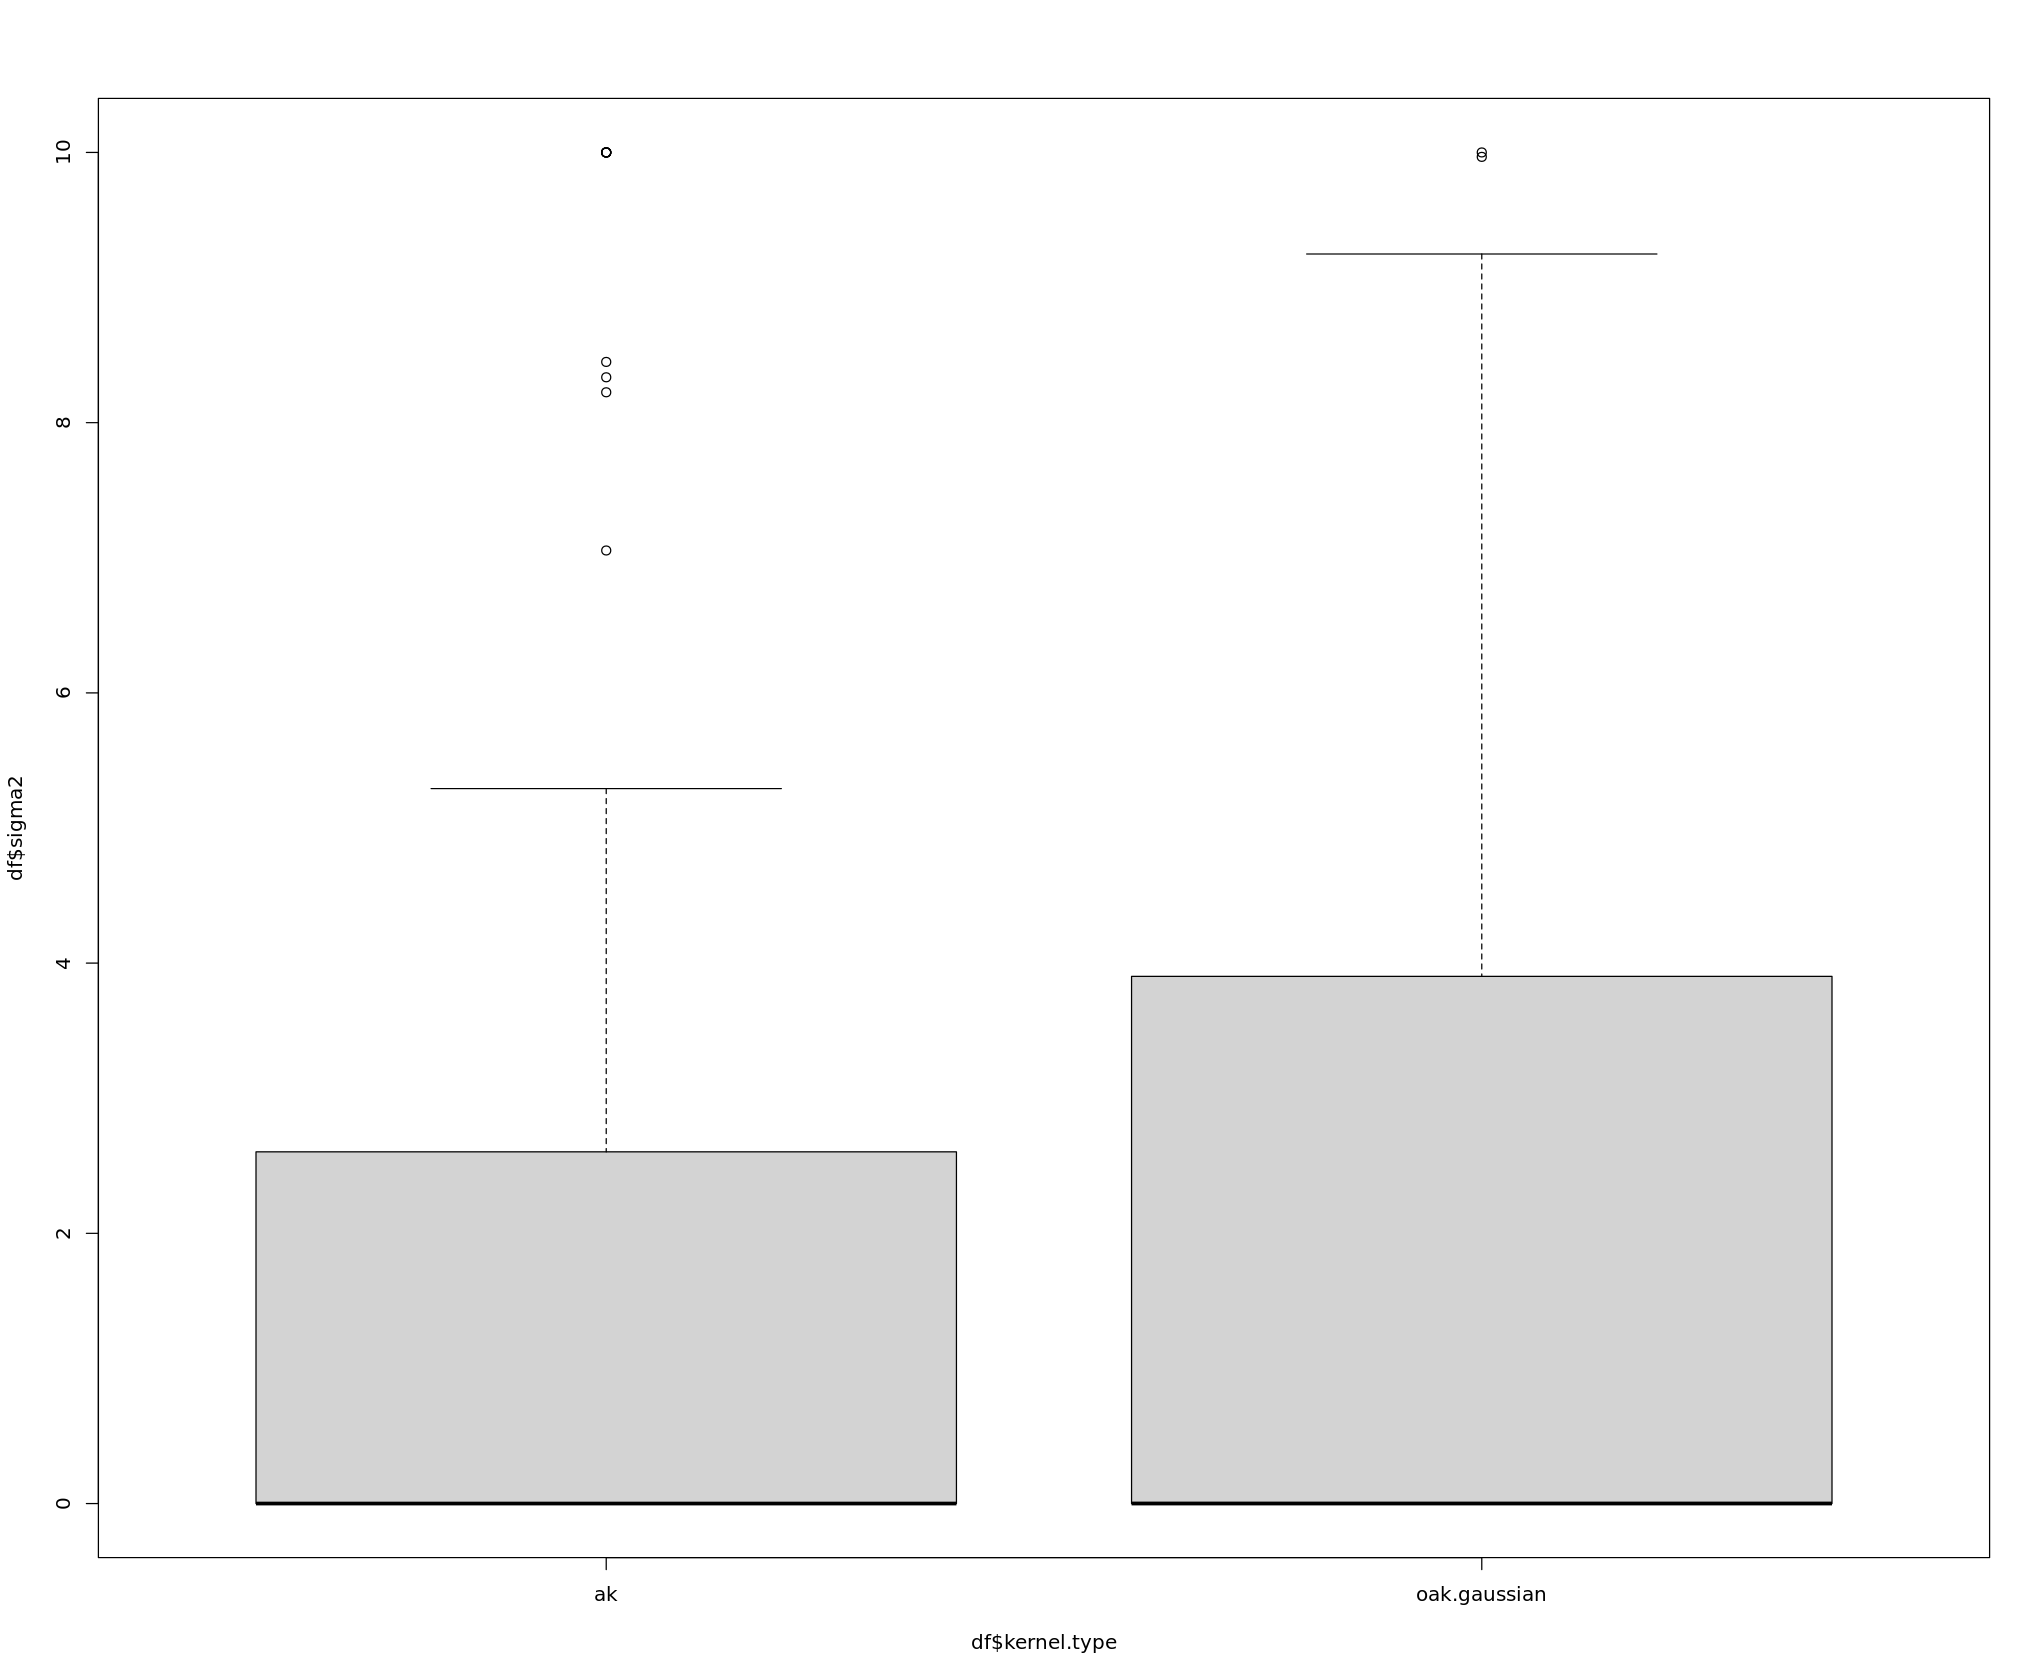

In [357]:
df <- df.result
df$ak$sigma0 <- NA
df$oak.gaussian$sigma0 <- df$oak.gaussian$sigma1
df$oak.gaussian$sigma1 <- df$oak.gaussian$sigma2
df$oak.gaussian$sigma2 <- df$oak.gaussian$sigma3
df$oak.gaussian$sigma3 <- NULL
df <- rbind(df$ak, df$oak.gaussian)
df[,2:7] <- lapply(df[,2:7], function(r) as.numeric(r))

boxplot(df$sigma2 ~ df$kernel.type)

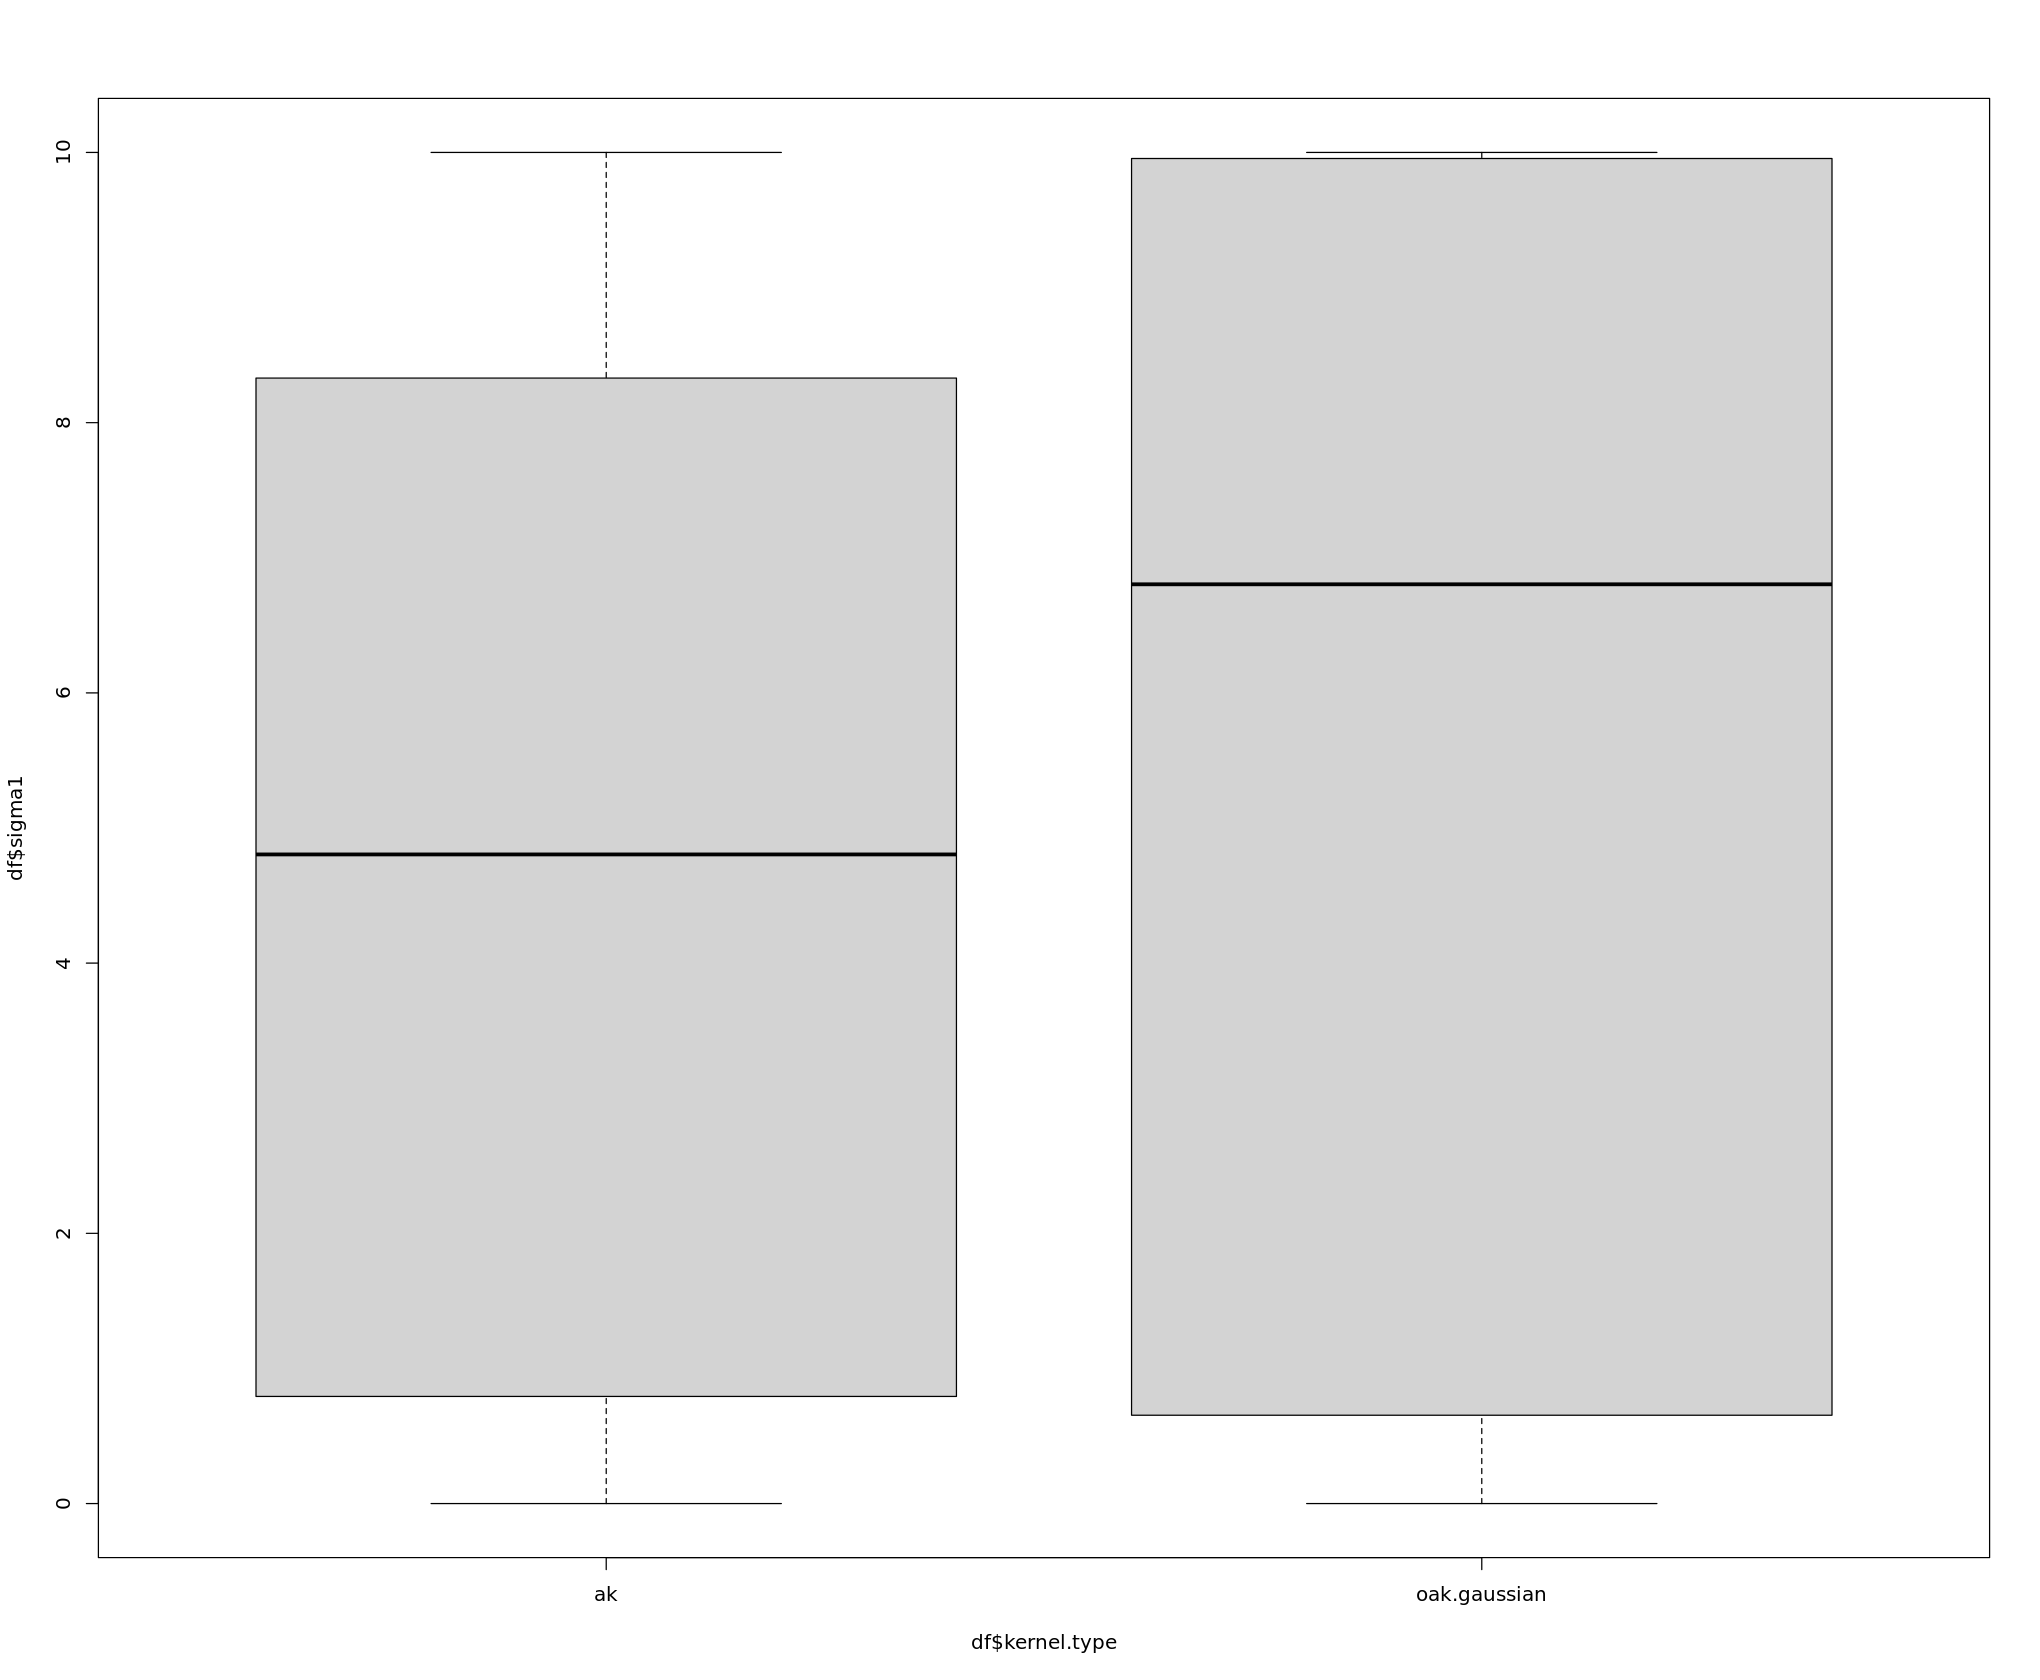

In [363]:
df2 <- df[df$mse<.001,]
boxplot(df$sigma1 ~ df$kernel.type)